In [1]:
# split into train and test set
import os
import numpy as np
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.utils import Dataset
import pydicom
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
import random
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# class that defines and loads the kangaroo dataset
class PlaqueDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("dataset", 1, "vessel")
        for folder in listdir(dataset_dir):
            sub_id = folder
            # skip all images after 150 if we are building the train set
            if is_train and int(sub_id[4:]) >= 100:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(sub_id[4:]) < 100:
                continue
            sub_dir = os.path.join(dataset_dir, folder)
            for file in listdir(sub_dir + '/contours'):
                slice_id = file[-8:-4]
                ch1_path = sub_dir + '/MASSExport/T1W_' + slice_id + '.dcm'
                ch2_path = sub_dir + '/MASSExport/3DTOF_' + slice_id + '.dcm'
                ch3_path = sub_dir + '/MASSExport/T2W_' + slice_id + '.dcm'
                mask_path = sub_dir + '/contours/' + file
                mask_dcm = pydicom.read_file(mask_path, force = True)
                mask_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
                mask = mask_dcm.pixel_array
                mask_xmin = np.min(np.where(mask > 0)[0])
                mask_xmax = np.max(np.where(mask > 0)[0])
                mask_ymin = np.min(np.where(mask > 0)[1])
                mask_ymax = np.max(np.where(mask > 0)[1])
                self.add_image('dataset', 
                               image_id=sub_id+'_'+slice_id, 
                               path=[ch1_path, ch2_path, ch3_path], 
                               annotation=mask_path, 
                               crop = [mask_xmin-random.randint(15, 25), 
                                       mask_xmax+random.randint(15, 25), 
                                       mask_ymin-random.randint(15, 25), 
                                       mask_ymax+random.randint(15, 25)])
 
    # load the masks for an image
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        crop = info['crop']
        mask_dcm = pydicom.read_file(path, force = True)
        mask_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        mask_big = (mask_dcm.pixel_array>0).astype(np.uint8)
        mask = mask_big[crop[2]:crop[3], crop[0]:crop[1], np.newaxis]
        class_id = [self.class_names.index('vessel')]
        return mask, asarray(class_id, dtype='int32')
    
    def load_image(self, image_id):
        info = self.image_info[image_id]
        path = info['path']
        crop = info['crop']
        path_mask = info['annotation']
        mask_dcm = pydicom.read_file(path_mask, force = True)
        mask_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        mask_big = (mask_dcm.pixel_array>0).astype(np.uint8)
        ch1_dcm = pydicom.read_file(path[0], force = True)
        ch2_dcm = pydicom.read_file(path[1], force = True)
        ch3_dcm = pydicom.read_file(path[2], force = True)
        ch1_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        ch2_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        ch3_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        ch1_img = ch1_dcm.pixel_array
        ch2_img = ch2_dcm.pixel_array
        ch3_img = ch3_dcm.pixel_array
        ch1_min = np.min(ch1_img) #!!!
        ch1_max = np.max(ch1_img) #!!!
        ch2_min = np.min(ch2_img) #!!!
        ch2_max = np.max(ch2_img) #!!!
        ch3_min = np.min(ch3_img) #!!!
        ch3_max = np.max(ch3_img) #!!!
        ch1_img = ((ch1_img - ch1_min)/(ch1_max - ch1_min)*255).astype(np.uint8)[crop[2]:crop[3], crop[0]:crop[1]]
        ch2_img = ((ch2_img - ch2_min)/(ch2_max - ch2_min)*255).astype(np.uint8)[crop[2]:crop[3], crop[0]:crop[1]]
        ch3_img = ((ch3_img - ch3_min)/(ch3_max - ch3_min)*255).astype(np.uint8)[crop[2]:crop[3], crop[0]:crop[1]]
        
        return np.dstack((ch1_img, ch2_img, ch3_img))
 
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [3]:
train_set = PlaqueDataset()
train_set.load_dataset('Z:/Lisa/PARISK/PARISK_curated/', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

Train: 761


In [4]:
test_set = PlaqueDataset()
test_set.load_dataset('Z:/Lisa/PARISK/PARISK_curated/', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Test: 337


(77, 62, 3)
(77, 62, 1)


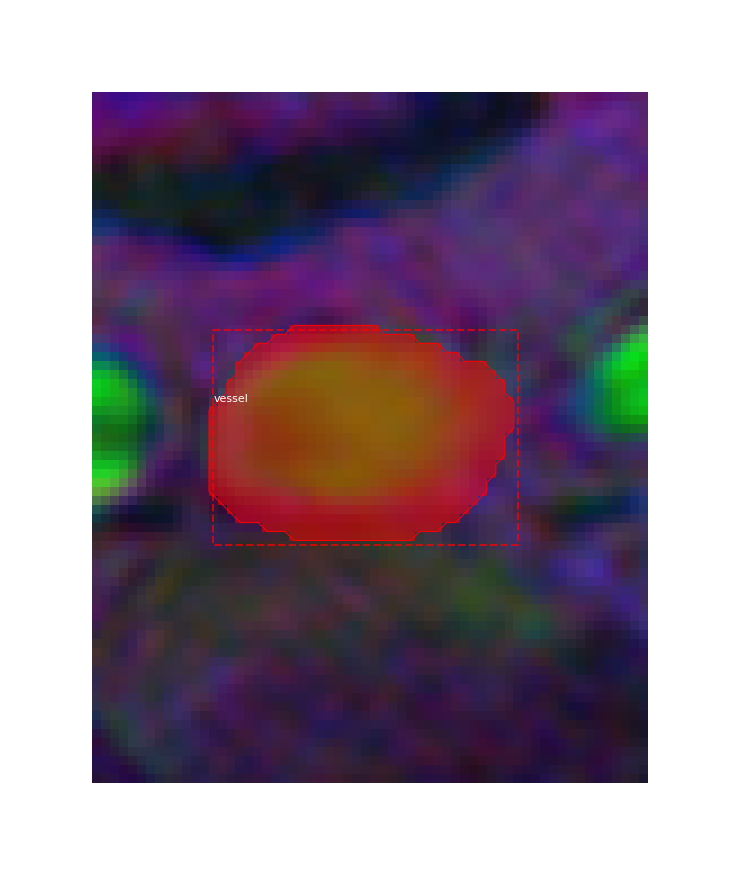

In [5]:
image_id = 216
image = train_set.load_image(image_id)
print(image.shape)
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
bbox = extract_bboxes(mask)
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [30]:
# define a configuration for the model
class PlaqueConfig(Config):
    # define the name of the configuration
    NAME = "plaque_cfg"
    # number of classes (background + plaque)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    STEPS_PER_EPOCH = 700

In [31]:
config = PlaqueConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [32]:
model = MaskRCNN(mode='training', model_dir='./', config=config)
model.load_weights('mask_rcnn_coco.h5', by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./plaque_cfg20201031T2221\mask_rcnn_plaque_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Tim

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5


c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/700 [..............................] - ETA: 32:06:28 - loss: 3.0251 - rpn_class_loss: 0.0536 - rpn_bbox_loss: 1.2206 - mrcnn_class_loss: 0.2775 - mrcnn_bbox_loss: 1.0827 - mrcnn_mask_loss: 0.3907

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/700 [..............................] - ETA: 30:58:22 - loss: 2.9039 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.9679 - mrcnn_class_loss: 0.2131 - mrcnn_bbox_loss: 1.1671 - mrcnn_mask_loss: 0.5281

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/700 [..............................] - ETA: 28:30:29 - loss: 2.8443 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.8398 - mrcnn_class_loss: 0.1652 - mrcnn_bbox_loss: 1.2344 - mrcnn_mask_loss: 0.5806

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/700 [..............................] - ETA: 28:01:52 - loss: 2.8335 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.8665 - mrcnn_class_loss: 0.1316 - mrcnn_bbox_loss: 1.2184 - mrcnn_mask_loss: 0.5968

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/700 [..............................] - ETA: 26:46:15 - loss: 2.7755 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.8303 - mrcnn_class_loss: 0.1274 - mrcnn_bbox_loss: 1.2063 - mrcnn_mask_loss: 0.5771

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/700 [..............................] - ETA: 26:20:50 - loss: 2.6239 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 0.7868 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 1.1004 - mrcnn_mask_loss: 0.5821

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/700 [..............................] - ETA: 26:31:39 - loss: 2.5942 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 0.7910 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 1.0733 - mrcnn_mask_loss: 0.5773

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/700 [..............................] - ETA: 26:05:34 - loss: 2.4375 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.7215 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 1.0074 - mrcnn_mask_loss: 0.5608

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/700 [..............................] - ETA: 25:40:47 - loss: 2.4301 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 0.7631 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.9783 - mrcnn_mask_loss: 0.5488

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/700 [..............................] - ETA: 25:10:51 - loss: 2.3856 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 0.7608 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.9610 - mrcnn_mask_loss: 0.5310

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/700 [..............................] - ETA: 24:54:03 - loss: 2.3200 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 0.7204 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.9505 - mrcnn_mask_loss: 0.5136

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/700 [..............................] - ETA: 24:26:30 - loss: 2.3820 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.7572 - mrcnn_class_loss: 0.0883 - mrcnn_bbox_loss: 0.9734 - mrcnn_mask_loss: 0.5152

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/700 [..............................] - ETA: 24:34:47 - loss: 2.4691 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 0.8194 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.9765 - mrcnn_mask_loss: 0.5219

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/700 [..............................] - ETA: 24:55:48 - loss: 2.4432 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 0.8092 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.9621 - mrcnn_mask_loss: 0.5286

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/700 [..............................] - ETA: 24:49:53 - loss: 2.4283 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.8132 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.9444 - mrcnn_mask_loss: 0.5276

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/700 [..............................] - ETA: 24:35:46 - loss: 2.3814 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.7964 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.9209 - mrcnn_mask_loss: 0.5202

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/700 [..............................] - ETA: 24:32:32 - loss: 2.5215 - rpn_class_loss: 0.0993 - rpn_bbox_loss: 0.9702 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.8668 - mrcnn_mask_loss: 0.4896

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/700 [..............................] - ETA: 24:14:11 - loss: 2.4614 - rpn_class_loss: 0.0940 - rpn_bbox_loss: 0.9252 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.8636 - mrcnn_mask_loss: 0.4836

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/700 [..............................] - ETA: 24:12:35 - loss: 2.4174 - rpn_class_loss: 0.0892 - rpn_bbox_loss: 0.8918 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.8596 - mrcnn_mask_loss: 0.4857

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/700 [..............................] - ETA: 24:24:49 - loss: 2.3693 - rpn_class_loss: 0.0847 - rpn_bbox_loss: 0.8667 - mrcnn_class_loss: 0.0875 - mrcnn_bbox_loss: 0.8556 - mrcnn_mask_loss: 0.4749

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/700 [..............................] - ETA: 24:16:56 - loss: 2.3327 - rpn_class_loss: 0.0831 - rpn_bbox_loss: 0.8463 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.8416 - mrcnn_mask_loss: 0.4694

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/700 [..............................] - ETA: 24:09:10 - loss: 2.2903 - rpn_class_loss: 0.0839 - rpn_bbox_loss: 0.8249 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.8288 - mrcnn_mask_loss: 0.4637

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/700 [..............................] - ETA: 24:00:39 - loss: 2.2799 - rpn_class_loss: 0.0817 - rpn_bbox_loss: 0.8265 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.8210 - mrcnn_mask_loss: 0.4635

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/700 [>.............................] - ETA: 23:52:44 - loss: 2.2530 - rpn_class_loss: 0.0808 - rpn_bbox_loss: 0.8171 - mrcnn_class_loss: 0.0854 - mrcnn_bbox_loss: 0.8096 - mrcnn_mask_loss: 0.4600

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/700 [>.............................] - ETA: 23:51:59 - loss: 2.2410 - rpn_class_loss: 0.0811 - rpn_bbox_loss: 0.8135 - mrcnn_class_loss: 0.0859 - mrcnn_bbox_loss: 0.7992 - mrcnn_mask_loss: 0.4613

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/700 [>.............................] - ETA: 23:56:06 - loss: 2.2089 - rpn_class_loss: 0.0779 - rpn_bbox_loss: 0.7936 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 0.7991 - mrcnn_mask_loss: 0.4549

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/700 [>.............................] - ETA: 23:54:46 - loss: 2.2071 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 0.7908 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.8031 - mrcnn_mask_loss: 0.4528

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/700 [>.............................] - ETA: 23:52:10 - loss: 2.2977 - rpn_class_loss: 0.1285 - rpn_bbox_loss: 0.8335 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.8031 - mrcnn_mask_loss: 0.4516

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/700 [>.............................] - ETA: 23:44:55 - loss: 2.2581 - rpn_class_loss: 0.1241 - rpn_bbox_loss: 0.8113 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.7903 - mrcnn_mask_loss: 0.4531

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/700 [>.............................] - ETA: 23:38:13 - loss: 2.2307 - rpn_class_loss: 0.1215 - rpn_bbox_loss: 0.7954 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.7855 - mrcnn_mask_loss: 0.4498

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/700 [>.............................] - ETA: 23:37:00 - loss: 2.2111 - rpn_class_loss: 0.1189 - rpn_bbox_loss: 0.7769 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.7898 - mrcnn_mask_loss: 0.4475

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/700 [>.............................] - ETA: 23:27:49 - loss: 2.2033 - rpn_class_loss: 0.1171 - rpn_bbox_loss: 0.7647 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.7966 - mrcnn_mask_loss: 0.4485

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/700 [>.............................] - ETA: 23:19:31 - loss: 2.1974 - rpn_class_loss: 0.1139 - rpn_bbox_loss: 0.7640 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.7914 - mrcnn_mask_loss: 0.4520

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/700 [>.............................] - ETA: 23:10:23 - loss: 2.1774 - rpn_class_loss: 0.1118 - rpn_bbox_loss: 0.7524 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.7838 - mrcnn_mask_loss: 0.4540

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/700 [>.............................] - ETA: 23:15:04 - loss: 2.1614 - rpn_class_loss: 0.1138 - rpn_bbox_loss: 0.7495 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.7743 - mrcnn_mask_loss: 0.4495

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/700 [>.............................] - ETA: 23:11:25 - loss: 2.1423 - rpn_class_loss: 0.1120 - rpn_bbox_loss: 0.7473 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.7664 - mrcnn_mask_loss: 0.4439

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/700 [>.............................] - ETA: 23:09:28 - loss: 2.1465 - rpn_class_loss: 0.1096 - rpn_bbox_loss: 0.7618 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.7584 - mrcnn_mask_loss: 0.4447

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/700 [>.............................] - ETA: 23:05:22 - loss: 2.1240 - rpn_class_loss: 0.1067 - rpn_bbox_loss: 0.7538 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.7509 - mrcnn_mask_loss: 0.4413

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/700 [>.............................] - ETA: 23:11:46 - loss: 2.1001 - rpn_class_loss: 0.1041 - rpn_bbox_loss: 0.7392 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.7471 - mrcnn_mask_loss: 0.4395

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/700 [>.............................] - ETA: 23:06:46 - loss: 2.0724 - rpn_class_loss: 0.1016 - rpn_bbox_loss: 0.7234 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.7440 - mrcnn_mask_loss: 0.4337

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/700 [>.............................] - ETA: 23:03:23 - loss: 2.0521 - rpn_class_loss: 0.0992 - rpn_bbox_loss: 0.7171 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.7349 - mrcnn_mask_loss: 0.4321

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/700 [>.............................] - ETA: 23:03:42 - loss: 2.0541 - rpn_class_loss: 0.0987 - rpn_bbox_loss: 0.7083 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.7381 - mrcnn_mask_loss: 0.4407

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/700 [>.............................] - ETA: 23:04:21 - loss: 2.0255 - rpn_class_loss: 0.0966 - rpn_bbox_loss: 0.6940 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.7309 - mrcnn_mask_loss: 0.4369

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/700 [>.............................] - ETA: 22:59:42 - loss: 1.9978 - rpn_class_loss: 0.0945 - rpn_bbox_loss: 0.6812 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.7209 - mrcnn_mask_loss: 0.4348

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/700 [>.............................] - ETA: 22:55:14 - loss: 1.9759 - rpn_class_loss: 0.0924 - rpn_bbox_loss: 0.6754 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.7113 - mrcnn_mask_loss: 0.4313

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/700 [>.............................] - ETA: 22:51:43 - loss: 1.9696 - rpn_class_loss: 0.0915 - rpn_bbox_loss: 0.6668 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.7084 - mrcnn_mask_loss: 0.4384

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/700 [=>............................] - ETA: 22:52:24 - loss: 1.9458 - rpn_class_loss: 0.0896 - rpn_bbox_loss: 0.6548 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.6997 - mrcnn_mask_loss: 0.4385

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/700 [=>............................] - ETA: 22:48:38 - loss: 1.9311 - rpn_class_loss: 0.0886 - rpn_bbox_loss: 0.6464 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.6952 - mrcnn_mask_loss: 0.4380

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/700 [=>............................] - ETA: 22:43:37 - loss: 1.9630 - rpn_class_loss: 0.0970 - rpn_bbox_loss: 0.6713 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.6912 - mrcnn_mask_loss: 0.4411

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/700 [=>............................] - ETA: 22:45:25 - loss: 1.9443 - rpn_class_loss: 0.0951 - rpn_bbox_loss: 0.6605 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.6876 - mrcnn_mask_loss: 0.4395

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/700 [=>............................] - ETA: 22:45:02 - loss: 1.9267 - rpn_class_loss: 0.0933 - rpn_bbox_loss: 0.6516 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.6837 - mrcnn_mask_loss: 0.4371

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/700 [=>............................] - ETA: 22:39:15 - loss: 1.9128 - rpn_class_loss: 0.0918 - rpn_bbox_loss: 0.6441 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.6788 - mrcnn_mask_loss: 0.4373

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/700 [=>............................] - ETA: 22:36:05 - loss: 1.8895 - rpn_class_loss: 0.0902 - rpn_bbox_loss: 0.6343 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.6709 - mrcnn_mask_loss: 0.4343

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/700 [=>............................] - ETA: 22:30:38 - loss: 1.8666 - rpn_class_loss: 0.0886 - rpn_bbox_loss: 0.6256 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.6625 - mrcnn_mask_loss: 0.4309

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/700 [=>............................] - ETA: 22:23:57 - loss: 1.8648 - rpn_class_loss: 0.0883 - rpn_bbox_loss: 0.6186 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.6672 - mrcnn_mask_loss: 0.4316

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/700 [=>............................] - ETA: 22:22:23 - loss: 1.8430 - rpn_class_loss: 0.0868 - rpn_bbox_loss: 0.6088 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.6600 - mrcnn_mask_loss: 0.4290

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/700 [=>............................] - ETA: 22:23:26 - loss: 1.8489 - rpn_class_loss: 0.0866 - rpn_bbox_loss: 0.6044 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.6678 - mrcnn_mask_loss: 0.4316

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/700 [=>............................] - ETA: 22:18:40 - loss: 1.8352 - rpn_class_loss: 0.0854 - rpn_bbox_loss: 0.5996 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.6625 - mrcnn_mask_loss: 0.4301

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/700 [=>............................] - ETA: 22:14:25 - loss: 1.8265 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 0.5998 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.6575 - mrcnn_mask_loss: 0.4275

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/700 [=>............................] - ETA: 22:11:11 - loss: 1.8193 - rpn_class_loss: 0.0838 - rpn_bbox_loss: 0.5938 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.6572 - mrcnn_mask_loss: 0.4277

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/700 [=>............................] - ETA: 22:05:31 - loss: 1.8130 - rpn_class_loss: 0.0825 - rpn_bbox_loss: 0.5915 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.6563 - mrcnn_mask_loss: 0.4261

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/700 [=>............................] - ETA: 21:59:35 - loss: 1.7993 - rpn_class_loss: 0.0812 - rpn_bbox_loss: 0.5855 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.6531 - mrcnn_mask_loss: 0.4236

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/700 [=>............................] - ETA: 21:55:01 - loss: 1.7946 - rpn_class_loss: 0.0806 - rpn_bbox_loss: 0.5864 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.6487 - mrcnn_mask_loss: 0.4231

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/700 [=>............................] - ETA: 21:53:52 - loss: 1.7825 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 0.5822 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.6442 - mrcnn_mask_loss: 0.4213

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/700 [=>............................] - ETA: 21:49:53 - loss: 1.7690 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 0.5760 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.6394 - mrcnn_mask_loss: 0.4197

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/700 [=>............................] - ETA: 21:47:40 - loss: 1.7563 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 0.5730 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.6334 - mrcnn_mask_loss: 0.4177

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/700 [=>............................] - ETA: 21:48:53 - loss: 1.7447 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 0.5687 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.6292 - mrcnn_mask_loss: 0.4162

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/700 [=>............................] - ETA: 21:46:57 - loss: 1.7327 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 0.5648 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.6252 - mrcnn_mask_loss: 0.4136

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/700 [=>............................] - ETA: 21:42:25 - loss: 1.7299 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 0.5639 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.6237 - mrcnn_mask_loss: 0.4141

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/700 [==>...........................] - ETA: 21:45:45 - loss: 1.7180 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 0.5588 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.6200 - mrcnn_mask_loss: 0.4123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/700 [==>...........................] - ETA: 21:43:51 - loss: 1.7077 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 0.5548 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.6164 - mrcnn_mask_loss: 0.4111

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/700 [==>...........................] - ETA: 21:45:31 - loss: 1.7119 - rpn_class_loss: 0.0851 - rpn_bbox_loss: 0.5620 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.6078 - mrcnn_mask_loss: 0.4054

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/700 [==>...........................] - ETA: 21:46:45 - loss: 1.7115 - rpn_class_loss: 0.0842 - rpn_bbox_loss: 0.5661 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.6050 - mrcnn_mask_loss: 0.4048

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/700 [==>...........................] - ETA: 21:47:52 - loss: 1.7069 - rpn_class_loss: 0.0836 - rpn_bbox_loss: 0.5635 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.6034 - mrcnn_mask_loss: 0.4052

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/700 [==>...........................] - ETA: 21:50:37 - loss: 1.7008 - rpn_class_loss: 0.0829 - rpn_bbox_loss: 0.5591 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.6035 - mrcnn_mask_loss: 0.4041

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/700 [==>...........................] - ETA: 21:49:22 - loss: 1.6958 - rpn_class_loss: 0.0823 - rpn_bbox_loss: 0.5571 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.6018 - mrcnn_mask_loss: 0.4034

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/700 [==>...........................] - ETA: 21:45:56 - loss: 1.6854 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 0.5540 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.5973 - mrcnn_mask_loss: 0.4016

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/700 [==>...........................] - ETA: 21:46:03 - loss: 1.6717 - rpn_class_loss: 0.0807 - rpn_bbox_loss: 0.5485 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.5929 - mrcnn_mask_loss: 0.3992

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/700 [==>...........................] - ETA: 21:45:17 - loss: 1.6651 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 0.5433 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.5917 - mrcnn_mask_loss: 0.3999

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/700 [==>...........................] - ETA: 21:41:05 - loss: 1.6537 - rpn_class_loss: 0.0792 - rpn_bbox_loss: 0.5402 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.5862 - mrcnn_mask_loss: 0.3981

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/700 [==>...........................] - ETA: 21:39:05 - loss: 1.6446 - rpn_class_loss: 0.0784 - rpn_bbox_loss: 0.5349 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.5848 - mrcnn_mask_loss: 0.3969

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/700 [==>...........................] - ETA: 21:39:32 - loss: 1.6317 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 0.5291 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.5798 - mrcnn_mask_loss: 0.3959

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/700 [==>...........................] - ETA: 21:36:48 - loss: 1.6268 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 0.5281 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.5776 - mrcnn_mask_loss: 0.3950

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/700 [==>...........................] - ETA: 21:39:02 - loss: 1.6186 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 0.5250 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.5752 - mrcnn_mask_loss: 0.3934

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/700 [==>...........................] - ETA: 21:35:00 - loss: 1.6094 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 0.5239 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.5705 - mrcnn_mask_loss: 0.3904

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/700 [==>...........................] - ETA: 21:31:29 - loss: 1.6013 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.5218 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.5665 - mrcnn_mask_loss: 0.3891

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/700 [==>...........................] - ETA: 21:28:40 - loss: 1.5917 - rpn_class_loss: 0.0750 - rpn_bbox_loss: 0.5172 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.5636 - mrcnn_mask_loss: 0.3881

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/700 [==>...........................] - ETA: 21:25:54 - loss: 1.6119 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 0.5356 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.5620 - mrcnn_mask_loss: 0.3895

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/700 [==>...........................] - ETA: 21:22:14 - loss: 1.6042 - rpn_class_loss: 0.0766 - rpn_bbox_loss: 0.5328 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.5594 - mrcnn_mask_loss: 0.3881

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/700 [==>...........................] - ETA: 21:22:03 - loss: 1.6059 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 0.5328 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.5588 - mrcnn_mask_loss: 0.3909

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/700 [==>...........................] - ETA: 21:20:22 - loss: 1.5973 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.5288 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.5560 - mrcnn_mask_loss: 0.3900

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/700 [==>...........................] - ETA: 21:18:24 - loss: 1.5884 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 0.5255 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.5525 - mrcnn_mask_loss: 0.3891

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/700 [==>...........................] - ETA: 21:16:22 - loss: 1.5784 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 0.5211 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.5486 - mrcnn_mask_loss: 0.3883

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/700 [===>..........................] - ETA: 21:14:00 - loss: 1.5696 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 0.5170 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.5461 - mrcnn_mask_loss: 0.3870

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/700 [===>..........................] - ETA: 21:09:53 - loss: 1.5597 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 0.5124 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.5432 - mrcnn_mask_loss: 0.3855

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/700 [===>..........................] - ETA: 21:06:30 - loss: 1.5525 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 0.5098 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.5406 - mrcnn_mask_loss: 0.3843

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/700 [===>..........................] - ETA: 21:02:46 - loss: 1.5462 - rpn_class_loss: 0.0717 - rpn_bbox_loss: 0.5059 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.5385 - mrcnn_mask_loss: 0.3846

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/700 [===>..........................] - ETA: 21:00:09 - loss: 1.5394 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 0.5031 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.5357 - mrcnn_mask_loss: 0.3839

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/700 [===>..........................] - ETA: 20:56:46 - loss: 1.5361 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 0.5008 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.5351 - mrcnn_mask_loss: 0.3839

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/700 [===>..........................] - ETA: 20:55:52 - loss: 1.5342 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 0.4982 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.5370 - mrcnn_mask_loss: 0.3833

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/700 [===>..........................] - ETA: 20:58:52 - loss: 1.5311 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 0.4979 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.5354 - mrcnn_mask_loss: 0.3825

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/700 [===>..........................] - ETA: 20:55:01 - loss: 1.5283 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 0.4971 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.5348 - mrcnn_mask_loss: 0.3816

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/700 [===>..........................] - ETA: 20:51:49 - loss: 1.5221 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 0.4946 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.5335 - mrcnn_mask_loss: 0.3800

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/700 [===>..........................] - ETA: 20:48:58 - loss: 1.5143 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 0.4921 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.5304 - mrcnn_mask_loss: 0.3786

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/700 [===>..........................] - ETA: 20:48:33 - loss: 1.5200 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 0.4951 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.5271 - mrcnn_mask_loss: 0.3787

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/700 [===>..........................] - ETA: 20:44:35 - loss: 1.5130 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 0.4923 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.5242 - mrcnn_mask_loss: 0.3784

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/700 [===>..........................] - ETA: 20:42:07 - loss: 1.5106 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 0.4919 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.5220 - mrcnn_mask_loss: 0.3790

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/700 [===>..........................] - ETA: 20:39:32 - loss: 1.5070 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 0.4891 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.5238 - mrcnn_mask_loss: 0.3772

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/700 [===>..........................] - ETA: 20:36:39 - loss: 1.5002 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 0.4861 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.5215 - mrcnn_mask_loss: 0.3764

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/700 [===>..........................] - ETA: 20:34:16 - loss: 1.4967 - rpn_class_loss: 0.0721 - rpn_bbox_loss: 0.4830 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.5225 - mrcnn_mask_loss: 0.3757

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/700 [===>..........................] - ETA: 20:31:23 - loss: 1.4893 - rpn_class_loss: 0.0716 - rpn_bbox_loss: 0.4795 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.5206 - mrcnn_mask_loss: 0.3745

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/700 [===>..........................] - ETA: 20:29:38 - loss: 1.4820 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 0.4763 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.5180 - mrcnn_mask_loss: 0.3739

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/700 [===>..........................] - ETA: 20:26:56 - loss: 1.4809 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 0.4753 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.5200 - mrcnn_mask_loss: 0.3725

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/700 [===>..........................] - ETA: 20:24:19 - loss: 1.4739 - rpn_class_loss: 0.0703 - rpn_bbox_loss: 0.4722 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.5181 - mrcnn_mask_loss: 0.3711

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/700 [===>..........................] - ETA: 20:23:37 - loss: 1.4694 - rpn_class_loss: 0.0700 - rpn_bbox_loss: 0.4716 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.5151 - mrcnn_mask_loss: 0.3707

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/700 [===>..........................] - ETA: 20:22:13 - loss: 1.4667 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 0.4714 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.5144 - mrcnn_mask_loss: 0.3695

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/700 [====>.........................] - ETA: 20:19:37 - loss: 1.4601 - rpn_class_loss: 0.0692 - rpn_bbox_loss: 0.4681 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.5126 - mrcnn_mask_loss: 0.3687

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/700 [====>.........................] - ETA: 20:18:10 - loss: 1.4536 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 0.4662 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.5099 - mrcnn_mask_loss: 0.3676

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/700 [====>.........................] - ETA: 20:18:20 - loss: 1.4487 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 0.4639 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.5077 - mrcnn_mask_loss: 0.3677

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/700 [====>.........................] - ETA: 20:15:30 - loss: 1.4426 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 0.4618 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.5051 - mrcnn_mask_loss: 0.3670

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/700 [====>.........................] - ETA: 20:12:19 - loss: 1.4388 - rpn_class_loss: 0.0675 - rpn_bbox_loss: 0.4608 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.5040 - mrcnn_mask_loss: 0.3659

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/700 [====>.........................] - ETA: 20:11:38 - loss: 1.4321 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 0.4584 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.5014 - mrcnn_mask_loss: 0.3648

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/700 [====>.........................] - ETA: 20:10:57 - loss: 1.4269 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 0.4561 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.5002 - mrcnn_mask_loss: 0.3635

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/700 [====>.........................] - ETA: 20:07:56 - loss: 1.4251 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 0.4541 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.5010 - mrcnn_mask_loss: 0.3634

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/700 [====>.........................] - ETA: 20:05:18 - loss: 1.4210 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 0.4530 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.4993 - mrcnn_mask_loss: 0.3627

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/700 [====>.........................] - ETA: 20:02:00 - loss: 1.4164 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 0.4520 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.4969 - mrcnn_mask_loss: 0.3620

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/700 [====>.........................] - ETA: 20:01:38 - loss: 1.4226 - rpn_class_loss: 0.0692 - rpn_bbox_loss: 0.4569 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.4961 - mrcnn_mask_loss: 0.3605

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/700 [====>.........................] - ETA: 19:58:16 - loss: 1.4190 - rpn_class_loss: 0.0692 - rpn_bbox_loss: 0.4567 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.4937 - mrcnn_mask_loss: 0.3598

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/700 [====>.........................] - ETA: 19:55:10 - loss: 1.4148 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 0.4551 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.4928 - mrcnn_mask_loss: 0.3588

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/700 [====>.........................] - ETA: 19:52:57 - loss: 1.4094 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 0.4527 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.4906 - mrcnn_mask_loss: 0.3585

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/700 [====>.........................] - ETA: 19:49:13 - loss: 1.4036 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 0.4503 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.4889 - mrcnn_mask_loss: 0.3575

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/700 [====>.........................] - ETA: 19:46:49 - loss: 1.3995 - rpn_class_loss: 0.0676 - rpn_bbox_loss: 0.4478 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.4882 - mrcnn_mask_loss: 0.3570

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/700 [====>.........................] - ETA: 19:44:15 - loss: 1.3928 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 0.4458 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.4854 - mrcnn_mask_loss: 0.3557

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/700 [====>.........................] - ETA: 19:41:45 - loss: 1.3873 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 0.4438 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.4834 - mrcnn_mask_loss: 0.3547

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/700 [====>.........................] - ETA: 19:39:01 - loss: 1.3843 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 0.4431 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.4821 - mrcnn_mask_loss: 0.3542

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/700 [====>.........................] - ETA: 19:36:25 - loss: 1.4043 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 0.4571 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.4868 - mrcnn_mask_loss: 0.3546

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/700 [====>.........................] - ETA: 19:35:34 - loss: 1.4021 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 0.4553 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.4863 - mrcnn_mask_loss: 0.3551

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/700 [====>.........................] - ETA: 19:33:58 - loss: 1.3977 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 0.4532 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.4849 - mrcnn_mask_loss: 0.3547

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/700 [====>.........................] - ETA: 19:32:20 - loss: 1.3940 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 0.4515 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.4834 - mrcnn_mask_loss: 0.3545

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/700 [=====>........................] - ETA: 19:31:22 - loss: 1.3903 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 0.4502 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.4822 - mrcnn_mask_loss: 0.3537

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/700 [=====>........................] - ETA: 19:30:02 - loss: 1.3850 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 0.4487 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.4799 - mrcnn_mask_loss: 0.3526

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/700 [=====>........................] - ETA: 19:28:29 - loss: 1.3810 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 0.4468 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.4787 - mrcnn_mask_loss: 0.3522

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/700 [=====>........................] - ETA: 19:27:48 - loss: 1.3747 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 0.4449 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.4762 - mrcnn_mask_loss: 0.3509

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/700 [=====>........................] - ETA: 19:25:05 - loss: 1.3697 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 0.4423 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.4748 - mrcnn_mask_loss: 0.3505

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/700 [=====>........................] - ETA: 19:23:13 - loss: 1.3649 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 0.4412 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.4729 - mrcnn_mask_loss: 0.3492

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/700 [=====>........................] - ETA: 19:24:07 - loss: 1.3600 - rpn_class_loss: 0.0641 - rpn_bbox_loss: 0.4393 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.4713 - mrcnn_mask_loss: 0.3484

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/700 [=====>........................] - ETA: 19:21:53 - loss: 1.3549 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 0.4372 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.4694 - mrcnn_mask_loss: 0.3476

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/700 [=====>........................] - ETA: 19:21:22 - loss: 1.3500 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 0.4355 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.4672 - mrcnn_mask_loss: 0.3470

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/700 [=====>........................] - ETA: 19:18:38 - loss: 1.3484 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 0.4339 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.4672 - mrcnn_mask_loss: 0.3472

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/700 [=====>........................] - ETA: 19:16:17 - loss: 1.3430 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 0.4314 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.4654 - mrcnn_mask_loss: 0.3468

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/700 [=====>........................] - ETA: 19:15:08 - loss: 1.3399 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 0.4294 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.4645 - mrcnn_mask_loss: 0.3470

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/700 [=====>........................] - ETA: 19:13:12 - loss: 1.3337 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.4270 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.4624 - mrcnn_mask_loss: 0.3460

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/700 [=====>........................] - ETA: 19:10:33 - loss: 1.3303 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 0.4251 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.4616 - mrcnn_mask_loss: 0.3455

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/700 [=====>........................] - ETA: 19:08:28 - loss: 1.3263 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 0.4233 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.4605 - mrcnn_mask_loss: 0.3449

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/700 [=====>........................] - ETA: 19:07:29 - loss: 1.3255 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 0.4230 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.4595 - mrcnn_mask_loss: 0.3458

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/700 [=====>........................] - ETA: 19:05:28 - loss: 1.3211 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 0.4211 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.4578 - mrcnn_mask_loss: 0.3455

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/700 [=====>........................] - ETA: 19:03:08 - loss: 1.3166 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.4190 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.4565 - mrcnn_mask_loss: 0.3448

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/700 [=====>........................] - ETA: 19:01:07 - loss: 1.3164 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 0.4190 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.4563 - mrcnn_mask_loss: 0.3449

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/700 [=====>........................] - ETA: 18:59:10 - loss: 1.3123 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 0.4169 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.4554 - mrcnn_mask_loss: 0.3440

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/700 [=====>........................] - ETA: 18:58:23 - loss: 1.3107 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 0.4158 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.4554 - mrcnn_mask_loss: 0.3438

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/700 [=====>........................] - ETA: 18:57:52 - loss: 1.3093 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 0.4148 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.4545 - mrcnn_mask_loss: 0.3445

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/700 [=====>........................] - ETA: 18:56:44 - loss: 1.3047 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 0.4136 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.4526 - mrcnn_mask_loss: 0.3434

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/700 [=====>........................] - ETA: 18:54:05 - loss: 1.3009 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 0.4118 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.4512 - mrcnn_mask_loss: 0.3433

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/700 [======>.......................] - ETA: 18:52:36 - loss: 1.3003 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 0.4106 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.4517 - mrcnn_mask_loss: 0.3436

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/700 [======>.......................] - ETA: 18:50:24 - loss: 1.2966 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 0.4092 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.4503 - mrcnn_mask_loss: 0.3430

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/700 [======>.......................] - ETA: 18:48:57 - loss: 1.2923 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 0.4070 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.4491 - mrcnn_mask_loss: 0.3425

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/700 [======>.......................] - ETA: 18:46:53 - loss: 1.2990 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 0.4125 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.4489 - mrcnn_mask_loss: 0.3426

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/700 [======>.......................] - ETA: 18:46:55 - loss: 1.2986 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 0.4110 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.4500 - mrcnn_mask_loss: 0.3428

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/700 [======>.......................] - ETA: 18:46:34 - loss: 1.3030 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 0.4147 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.4483 - mrcnn_mask_loss: 0.3420

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/700 [======>.......................] - ETA: 18:44:29 - loss: 1.2981 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 0.4131 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.4462 - mrcnn_mask_loss: 0.3413

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/700 [======>.......................] - ETA: 18:42:59 - loss: 1.2942 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.4116 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.4447 - mrcnn_mask_loss: 0.3407

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/700 [======>.......................] - ETA: 18:42:14 - loss: 1.2901 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.4100 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.4433 - mrcnn_mask_loss: 0.3401

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/700 [======>.......................] - ETA: 18:40:21 - loss: 1.2858 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.4079 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.4419 - mrcnn_mask_loss: 0.3396

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/700 [======>.......................] - ETA: 18:38:45 - loss: 1.2820 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 0.4069 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.4399 - mrcnn_mask_loss: 0.3392

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/700 [======>.......................] - ETA: 18:36:10 - loss: 1.2775 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 0.4050 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.4384 - mrcnn_mask_loss: 0.3385

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/700 [======>.......................] - ETA: 18:34:28 - loss: 1.2738 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 0.4032 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.4369 - mrcnn_mask_loss: 0.3385

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/700 [======>.......................] - ETA: 18:32:04 - loss: 1.2689 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 0.4016 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.4350 - mrcnn_mask_loss: 0.3376

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/700 [======>.......................] - ETA: 18:31:17 - loss: 1.2643 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.3995 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.4338 - mrcnn_mask_loss: 0.3367

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/700 [======>.......................] - ETA: 18:29:29 - loss: 1.2622 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 0.3993 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.4323 - mrcnn_mask_loss: 0.3366

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/700 [======>.......................] - ETA: 18:27:29 - loss: 1.2581 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 0.3977 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.4308 - mrcnn_mask_loss: 0.3360

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/700 [======>.......................] - ETA: 18:26:09 - loss: 1.2551 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 0.3972 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.4294 - mrcnn_mask_loss: 0.3353

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/700 [======>.......................] - ETA: 18:25:27 - loss: 1.2526 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 0.3963 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.4284 - mrcnn_mask_loss: 0.3350

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/700 [======>.......................] - ETA: 18:23:53 - loss: 1.2478 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 0.3944 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.4267 - mrcnn_mask_loss: 0.3343

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/700 [======>.......................] - ETA: 18:23:50 - loss: 1.2450 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 0.3939 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.4252 - mrcnn_mask_loss: 0.3338

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/700 [======>.......................] - ETA: 18:21:43 - loss: 1.2413 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 0.3923 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.4239 - mrcnn_mask_loss: 0.3333

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/700 [======>.......................] - ETA: 18:19:03 - loss: 1.2391 - rpn_class_loss: 0.0588 - rpn_bbox_loss: 0.3919 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.4229 - mrcnn_mask_loss: 0.3328

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/700 [=======>......................] - ETA: 18:17:11 - loss: 1.2360 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.3908 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.4217 - mrcnn_mask_loss: 0.3323

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/700 [=======>......................] - ETA: 18:15:58 - loss: 1.2325 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 0.3890 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.4208 - mrcnn_mask_loss: 0.3318

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/700 [=======>......................] - ETA: 18:13:22 - loss: 1.2295 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 0.3876 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.4193 - mrcnn_mask_loss: 0.3319

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/700 [=======>......................] - ETA: 18:12:00 - loss: 1.2257 - rpn_class_loss: 0.0578 - rpn_bbox_loss: 0.3860 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.4178 - mrcnn_mask_loss: 0.3317

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/700 [=======>......................] - ETA: 18:09:26 - loss: 1.2224 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 0.3845 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.4170 - mrcnn_mask_loss: 0.3310

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/700 [=======>......................] - ETA: 18:08:42 - loss: 1.2202 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 0.3833 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.4162 - mrcnn_mask_loss: 0.3311

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/700 [=======>......................] - ETA: 18:08:32 - loss: 1.2167 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 0.3822 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.4147 - mrcnn_mask_loss: 0.3306

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/700 [=======>......................] - ETA: 18:07:52 - loss: 1.2141 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 0.3807 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.4139 - mrcnn_mask_loss: 0.3306

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/700 [=======>......................] - ETA: 18:06:04 - loss: 1.2109 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 0.3791 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.4129 - mrcnn_mask_loss: 0.3304

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/700 [=======>......................] - ETA: 18:04:29 - loss: 1.2075 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 0.3778 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.4118 - mrcnn_mask_loss: 0.3297

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/700 [=======>......................] - ETA: 18:02:15 - loss: 1.2036 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 0.3762 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.4104 - mrcnn_mask_loss: 0.3290

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/700 [=======>......................] - ETA: 18:00:17 - loss: 1.1999 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 0.3749 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.4089 - mrcnn_mask_loss: 0.3283

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/700 [=======>......................] - ETA: 17:58:04 - loss: 1.1987 - rpn_class_loss: 0.0557 - rpn_bbox_loss: 0.3744 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.4080 - mrcnn_mask_loss: 0.3287

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/700 [=======>......................] - ETA: 17:56:45 - loss: 1.1973 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 0.3733 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.4079 - mrcnn_mask_loss: 0.3286

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/700 [=======>......................] - ETA: 17:54:26 - loss: 1.1945 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 0.3726 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.4066 - mrcnn_mask_loss: 0.3280

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/700 [=======>......................] - ETA: 17:52:03 - loss: 1.1916 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 0.3711 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.4059 - mrcnn_mask_loss: 0.3276

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/700 [=======>......................] - ETA: 17:50:01 - loss: 1.1898 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 0.3702 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.4054 - mrcnn_mask_loss: 0.3274

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/700 [=======>......................] - ETA: 17:47:44 - loss: 1.1934 - rpn_class_loss: 0.0577 - rpn_bbox_loss: 0.3733 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.4040 - mrcnn_mask_loss: 0.3267

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/700 [=======>......................] - ETA: 17:45:55 - loss: 1.1899 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 0.3721 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.4026 - mrcnn_mask_loss: 0.3262

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/700 [=======>......................] - ETA: 17:46:23 - loss: 1.1859 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 0.3703 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.4013 - mrcnn_mask_loss: 0.3256

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/700 [=======>......................] - ETA: 17:44:35 - loss: 1.1828 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 0.3691 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.4001 - mrcnn_mask_loss: 0.3252

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/700 [=======>......................] - ETA: 17:42:00 - loss: 1.1827 - rpn_class_loss: 0.0568 - rpn_bbox_loss: 0.3681 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.4010 - mrcnn_mask_loss: 0.3254

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/700 [=======>......................] - ETA: 17:40:16 - loss: 1.1815 - rpn_class_loss: 0.0566 - rpn_bbox_loss: 0.3672 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.4013 - mrcnn_mask_loss: 0.3251

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/700 [========>.....................] - ETA: 17:40:07 - loss: 1.1780 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 0.3661 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.4001 - mrcnn_mask_loss: 0.3243

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/700 [========>.....................] - ETA: 17:38:29 - loss: 1.1754 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 0.3651 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.3989 - mrcnn_mask_loss: 0.3239

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/700 [========>.....................] - ETA: 17:38:26 - loss: 1.1715 - rpn_class_loss: 0.0560 - rpn_bbox_loss: 0.3635 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.3975 - mrcnn_mask_loss: 0.3233

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/700 [========>.....................] - ETA: 17:36:52 - loss: 1.1686 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 0.3623 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.3967 - mrcnn_mask_loss: 0.3228

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/700 [========>.....................] - ETA: 17:36:47 - loss: 1.1660 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 0.3610 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.3956 - mrcnn_mask_loss: 0.3228

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/700 [========>.....................] - ETA: 17:34:30 - loss: 1.1642 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 0.3600 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.3951 - mrcnn_mask_loss: 0.3229

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/700 [========>.....................] - ETA: 17:32:34 - loss: 1.1618 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 0.3588 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.3946 - mrcnn_mask_loss: 0.3225

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/700 [========>.....................] - ETA: 17:30:27 - loss: 1.1592 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 0.3579 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.3937 - mrcnn_mask_loss: 0.3219

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/700 [========>.....................] - ETA: 17:28:23 - loss: 1.1579 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 0.3581 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.3926 - mrcnn_mask_loss: 0.3216

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/700 [========>.....................] - ETA: 17:28:06 - loss: 1.1544 - rpn_class_loss: 0.0549 - rpn_bbox_loss: 0.3571 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.3913 - mrcnn_mask_loss: 0.3208

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/700 [========>.....................] - ETA: 17:27:54 - loss: 1.1521 - rpn_class_loss: 0.0547 - rpn_bbox_loss: 0.3565 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.3901 - mrcnn_mask_loss: 0.3205

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/700 [========>.....................] - ETA: 17:26:17 - loss: 1.1502 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 0.3554 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.3893 - mrcnn_mask_loss: 0.3208

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/700 [========>.....................] - ETA: 17:24:06 - loss: 1.1468 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 0.3543 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.3880 - mrcnn_mask_loss: 0.3201

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/700 [========>.....................] - ETA: 17:22:31 - loss: 1.1435 - rpn_class_loss: 0.0541 - rpn_bbox_loss: 0.3531 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.3193

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/700 [========>.....................] - ETA: 17:21:58 - loss: 1.1413 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 0.3520 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.3863 - mrcnn_mask_loss: 0.3190

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/700 [========>.....................] - ETA: 17:20:24 - loss: 1.1379 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 0.3506 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.3854 - mrcnn_mask_loss: 0.3183

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/700 [========>.....................] - ETA: 17:17:25 - loss: 1.1358 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 0.3500 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.3178

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/700 [========>.....................] - ETA: 17:16:32 - loss: 1.1337 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 0.3497 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.3173

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/700 [========>.....................] - ETA: 17:14:23 - loss: 1.1305 - rpn_class_loss: 0.0531 - rpn_bbox_loss: 0.3486 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.3824 - mrcnn_mask_loss: 0.3167

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/700 [========>.....................] - ETA: 17:11:34 - loss: 1.1285 - rpn_class_loss: 0.0529 - rpn_bbox_loss: 0.3480 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.3816 - mrcnn_mask_loss: 0.3163

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/700 [========>.....................] - ETA: 17:09:13 - loss: 1.1321 - rpn_class_loss: 0.0536 - rpn_bbox_loss: 0.3520 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.3809 - mrcnn_mask_loss: 0.3161

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/700 [========>.....................] - ETA: 17:09:08 - loss: 1.1297 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 0.3507 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.3800 - mrcnn_mask_loss: 0.3160

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/700 [========>.....................] - ETA: 17:06:25 - loss: 1.1264 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 0.3496 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.3788 - mrcnn_mask_loss: 0.3153

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/700 [========>.....................] - ETA: 17:06:08 - loss: 1.1241 - rpn_class_loss: 0.0531 - rpn_bbox_loss: 0.3495 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.3775 - mrcnn_mask_loss: 0.3146

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/700 [=========>....................] - ETA: 17:03:25 - loss: 1.1218 - rpn_class_loss: 0.0529 - rpn_bbox_loss: 0.3484 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.3769 - mrcnn_mask_loss: 0.3143

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/700 [=========>....................] - ETA: 17:01:33 - loss: 1.1198 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 0.3476 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.3760 - mrcnn_mask_loss: 0.3141

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/700 [=========>....................] - ETA: 16:59:24 - loss: 1.1170 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 0.3465 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.3750 - mrcnn_mask_loss: 0.3136

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/700 [=========>....................] - ETA: 16:57:29 - loss: 1.1153 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 0.3457 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.3744 - mrcnn_mask_loss: 0.3136

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/700 [=========>....................] - ETA: 16:55:18 - loss: 1.1127 - rpn_class_loss: 0.0523 - rpn_bbox_loss: 0.3445 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.3734 - mrcnn_mask_loss: 0.3133

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/700 [=========>....................] - ETA: 16:52:51 - loss: 1.1095 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 0.3432 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.3724 - mrcnn_mask_loss: 0.3128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/700 [=========>....................] - ETA: 16:52:23 - loss: 1.1088 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 0.3427 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.3727 - mrcnn_mask_loss: 0.3125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/700 [=========>....................] - ETA: 16:51:17 - loss: 1.1061 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 0.3416 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.3716 - mrcnn_mask_loss: 0.3122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/700 [=========>....................] - ETA: 16:48:55 - loss: 1.1043 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 0.3404 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.3717 - mrcnn_mask_loss: 0.3118

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/700 [=========>....................] - ETA: 16:46:54 - loss: 1.1023 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 0.3398 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.3708 - mrcnn_mask_loss: 0.3115

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/700 [=========>....................] - ETA: 16:44:40 - loss: 1.0993 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 0.3386 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.3698 - mrcnn_mask_loss: 0.3109

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/700 [=========>....................] - ETA: 16:42:38 - loss: 1.0972 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 0.3375 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.3690 - mrcnn_mask_loss: 0.3109

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/700 [=========>....................] - ETA: 16:40:30 - loss: 1.0946 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 0.3365 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.3682 - mrcnn_mask_loss: 0.3104

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/700 [=========>....................] - ETA: 16:38:48 - loss: 1.0919 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 0.3357 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.3671 - mrcnn_mask_loss: 0.3098

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/700 [=========>....................] - ETA: 16:37:11 - loss: 1.0900 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 0.3354 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.3661 - mrcnn_mask_loss: 0.3094

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/700 [=========>....................] - ETA: 16:35:09 - loss: 1.0872 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 0.3344 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.3651 - mrcnn_mask_loss: 0.3088

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/700 [=========>....................] - ETA: 16:32:58 - loss: 1.0918 - rpn_class_loss: 0.0523 - rpn_bbox_loss: 0.3386 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.3642 - mrcnn_mask_loss: 0.3083

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/700 [=========>....................] - ETA: 16:32:16 - loss: 1.0888 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 0.3374 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.3631 - mrcnn_mask_loss: 0.3079

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/700 [=========>....................] - ETA: 16:29:42 - loss: 1.0870 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 0.3368 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.3621 - mrcnn_mask_loss: 0.3078

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/700 [=========>....................] - ETA: 16:27:01 - loss: 1.0843 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 0.3359 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.3611 - mrcnn_mask_loss: 0.3072

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/700 [=========>....................] - ETA: 16:24:23 - loss: 1.0882 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 0.3390 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.3608 - mrcnn_mask_loss: 0.3080

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/700 [=========>....................] - ETA: 16:22:06 - loss: 1.0873 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 0.3391 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.3600 - mrcnn_mask_loss: 0.3079

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/700 [=========>....................] - ETA: 16:20:36 - loss: 1.0853 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 0.3383 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.3595 - mrcnn_mask_loss: 0.3075

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/700 [==========>...................] - ETA: 16:17:50 - loss: 1.0824 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 0.3373 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.3584 - mrcnn_mask_loss: 0.3069

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/700 [==========>...................] - ETA: 16:16:01 - loss: 1.0800 - rpn_class_loss: 0.0516 - rpn_bbox_loss: 0.3365 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.3574 - mrcnn_mask_loss: 0.3065

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/700 [==========>...................] - ETA: 16:14:36 - loss: 1.0774 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 0.3357 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.3563 - mrcnn_mask_loss: 0.3060

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/700 [==========>...................] - ETA: 16:12:14 - loss: 1.0756 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 0.3348 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.3554 - mrcnn_mask_loss: 0.3061

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/700 [==========>...................] - ETA: 16:09:57 - loss: 1.0728 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 0.3339 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.3544 - mrcnn_mask_loss: 0.3056

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/700 [==========>...................] - ETA: 16:07:38 - loss: 1.0703 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 0.3329 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.3536 - mrcnn_mask_loss: 0.3050

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/700 [==========>...................] - ETA: 16:05:10 - loss: 1.0687 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 0.3322 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.3530 - mrcnn_mask_loss: 0.3049

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/700 [==========>...................] - ETA: 16:03:12 - loss: 1.0670 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 0.3314 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.3526 - mrcnn_mask_loss: 0.3046

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/700 [==========>...................] - ETA: 16:00:59 - loss: 1.0653 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 0.3308 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.3520 - mrcnn_mask_loss: 0.3043

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/700 [==========>...................] - ETA: 15:58:59 - loss: 1.0641 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 0.3303 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.3512 - mrcnn_mask_loss: 0.3045

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/700 [==========>...................] - ETA: 15:56:44 - loss: 1.0628 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 0.3297 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.3509 - mrcnn_mask_loss: 0.3043

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/700 [==========>...................] - ETA: 15:54:51 - loss: 1.0606 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 0.3289 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.3500 - mrcnn_mask_loss: 0.3039

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/700 [==========>...................] - ETA: 15:52:28 - loss: 1.0605 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.3288 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.3496 - mrcnn_mask_loss: 0.3043

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/700 [==========>...................] - ETA: 15:51:04 - loss: 1.0584 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 0.3278 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.3488 - mrcnn_mask_loss: 0.3043

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/700 [==========>...................] - ETA: 15:48:36 - loss: 1.0557 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 0.3267 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.3480 - mrcnn_mask_loss: 0.3038

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/700 [==========>...................] - ETA: 15:46:14 - loss: 1.0532 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.3257 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.3471 - mrcnn_mask_loss: 0.3033

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/700 [==========>...................] - ETA: 15:44:08 - loss: 1.0507 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 0.3248 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.3460 - mrcnn_mask_loss: 0.3030

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/700 [==========>...................] - ETA: 15:42:59 - loss: 1.0480 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 0.3239 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.3451 - mrcnn_mask_loss: 0.3023

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/700 [==========>...................] - ETA: 15:40:28 - loss: 1.0466 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.3230 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.3447 - mrcnn_mask_loss: 0.3024

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/700 [==========>...................] - ETA: 15:38:30 - loss: 1.0438 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.3220 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.3438 - mrcnn_mask_loss: 0.3018

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/700 [==========>...................] - ETA: 15:36:01 - loss: 1.0429 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.3219 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.3434 - mrcnn_mask_loss: 0.3014

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/700 [==========>...................] - ETA: 15:34:12 - loss: 1.0416 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 0.3218 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.3427 - mrcnn_mask_loss: 0.3011

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/700 [==========>...................] - ETA: 15:32:53 - loss: 1.0468 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 0.3280 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.3417 - mrcnn_mask_loss: 0.3007

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/700 [===========>..................] - ETA: 15:30:47 - loss: 1.0454 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.3277 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.3411 - mrcnn_mask_loss: 0.3004

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/700 [===========>..................] - ETA: 15:28:23 - loss: 1.0437 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.3270 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.3405 - mrcnn_mask_loss: 0.3002

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/700 [===========>..................] - ETA: 15:26:10 - loss: 1.0415 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 0.3261 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.3397 - mrcnn_mask_loss: 0.2998

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/700 [===========>..................] - ETA: 15:23:42 - loss: 1.0388 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.3251 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.3388 - mrcnn_mask_loss: 0.2993

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/700 [===========>..................] - ETA: 15:21:38 - loss: 1.0367 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 0.3243 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.3382 - mrcnn_mask_loss: 0.2988

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/700 [===========>..................] - ETA: 15:19:25 - loss: 1.0340 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 0.3233 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.3373 - mrcnn_mask_loss: 0.2982

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/700 [===========>..................] - ETA: 15:16:45 - loss: 1.0323 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 0.3227 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.3366 - mrcnn_mask_loss: 0.2980

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/700 [===========>..................] - ETA: 15:14:27 - loss: 1.0308 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 0.3218 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.3363 - mrcnn_mask_loss: 0.2979

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/700 [===========>..................] - ETA: 15:12:35 - loss: 1.0291 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 0.3211 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.3355 - mrcnn_mask_loss: 0.2978

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/700 [===========>..................] - ETA: 15:10:14 - loss: 1.0275 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.3205 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.3347 - mrcnn_mask_loss: 0.2978

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/700 [===========>..................] - ETA: 15:07:35 - loss: 1.0263 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.3196 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.3346 - mrcnn_mask_loss: 0.2978

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/700 [===========>..................] - ETA: 15:05:14 - loss: 1.0252 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 0.3193 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.3341 - mrcnn_mask_loss: 0.2976

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/700 [===========>..................] - ETA: 15:03:00 - loss: 1.0233 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 0.3185 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.3336 - mrcnn_mask_loss: 0.2973

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/700 [===========>..................] - ETA: 15:00:57 - loss: 1.0218 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.3177 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.3331 - mrcnn_mask_loss: 0.2972

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/700 [===========>..................] - ETA: 14:59:16 - loss: 1.0196 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 0.3170 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.3323 - mrcnn_mask_loss: 0.2968

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/700 [===========>..................] - ETA: 14:56:36 - loss: 1.0198 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 0.3166 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.3329 - mrcnn_mask_loss: 0.2969

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/700 [===========>..................] - ETA: 14:53:52 - loss: 1.0181 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.3158 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.3322 - mrcnn_mask_loss: 0.2967

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/700 [===========>..................] - ETA: 14:51:18 - loss: 1.0155 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 0.3149 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.3313 - mrcnn_mask_loss: 0.2962

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/700 [===========>..................] - ETA: 14:49:46 - loss: 1.0136 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 0.3141 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.3306 - mrcnn_mask_loss: 0.2960

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/700 [===========>..................] - ETA: 14:48:12 - loss: 1.0156 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 0.3160 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.3296 - mrcnn_mask_loss: 0.2956

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/700 [===========>..................] - ETA: 14:45:48 - loss: 1.0137 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 0.3152 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.3289 - mrcnn_mask_loss: 0.2953

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/700 [===========>..................] - ETA: 14:43:28 - loss: 1.0120 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 0.3145 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.3286 - mrcnn_mask_loss: 0.2949

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/700 [===========>..................] - ETA: 14:41:02 - loss: 1.0098 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.3138 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.3278 - mrcnn_mask_loss: 0.2944

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/700 [===========>..................] - ETA: 14:39:22 - loss: 1.0083 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.3131 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.3273 - mrcnn_mask_loss: 0.2942

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/700 [============>.................] - ETA: 14:37:51 - loss: 1.0076 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 0.3126 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.3270 - mrcnn_mask_loss: 0.2945

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warni

305/700 [============>.................] - ETA: 14:37:03 - loss: 1.0066 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 0.3125 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.3265 - mrcnn_mask_loss: 0.2943

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/700 [============>.................] - ETA: 14:34:30 - loss: 1.0046 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.3116 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.3256 - mrcnn_mask_loss: 0.2943

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/700 [============>.................] - ETA: 14:33:15 - loss: 1.0044 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.3119 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.3248 - mrcnn_mask_loss: 0.2947

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/700 [============>.................] - ETA: 14:30:58 - loss: 1.0026 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.3113 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.3242 - mrcnn_mask_loss: 0.2943

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/700 [============>.................] - ETA: 14:28:32 - loss: 1.0026 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.3109 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.3241 - mrcnn_mask_loss: 0.2948

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/700 [============>.................] - ETA: 14:26:31 - loss: 1.0005 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 0.3101 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.3234 - mrcnn_mask_loss: 0.2944

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/700 [============>.................] - ETA: 14:23:47 - loss: 0.9985 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 0.3093 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.3227 - mrcnn_mask_loss: 0.2940

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/700 [============>.................] - ETA: 14:21:42 - loss: 0.9969 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 0.3086 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.3223 - mrcnn_mask_loss: 0.2938

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/700 [============>.................] - ETA: 14:20:36 - loss: 0.9955 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 0.3080 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.3218 - mrcnn_mask_loss: 0.2935

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/700 [============>.................] - ETA: 14:18:22 - loss: 0.9936 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 0.3073 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.3212 - mrcnn_mask_loss: 0.2931

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/700 [============>.................] - ETA: 14:16:27 - loss: 0.9917 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 0.3064 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.3205 - mrcnn_mask_loss: 0.2929

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/700 [============>.................] - ETA: 14:14:45 - loss: 0.9913 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 0.3060 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.3205 - mrcnn_mask_loss: 0.2930

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/700 [============>.................] - ETA: 14:13:00 - loss: 0.9900 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 0.3054 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.3202 - mrcnn_mask_loss: 0.2929

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/700 [============>.................] - ETA: 14:10:29 - loss: 0.9893 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 0.3052 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.3197 - mrcnn_mask_loss: 0.2929

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/700 [============>.................] - ETA: 14:08:40 - loss: 0.9879 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.3045 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.3195 - mrcnn_mask_loss: 0.2926

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/700 [============>.................] - ETA: 14:06:28 - loss: 0.9900 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 0.3076 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.3189 - mrcnn_mask_loss: 0.2922

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/700 [============>.................] - ETA: 14:05:08 - loss: 0.9885 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.3070 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.3184 - mrcnn_mask_loss: 0.2919

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/700 [============>.................] - ETA: 14:03:32 - loss: 0.9876 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.3065 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.3181 - mrcnn_mask_loss: 0.2919

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/700 [============>.................] - ETA: 14:01:33 - loss: 0.9863 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 0.3063 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.3175 - mrcnn_mask_loss: 0.2916

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/700 [============>.................] - ETA: 13:59:09 - loss: 0.9848 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.3057 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.3171 - mrcnn_mask_loss: 0.2913

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/700 [============>.................] - ETA: 13:56:41 - loss: 0.9827 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.3049 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.3164 - mrcnn_mask_loss: 0.2908

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/700 [============>.................] - ETA: 13:54:31 - loss: 0.9809 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.3042 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.3158 - mrcnn_mask_loss: 0.2904

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/700 [=============>................] - ETA: 13:52:46 - loss: 0.9788 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 0.3033 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.3150 - mrcnn_mask_loss: 0.2900

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/700 [=============>................] - ETA: 13:50:30 - loss: 0.9769 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 0.3026 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.3143 - mrcnn_mask_loss: 0.2898

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/700 [=============>................] - ETA: 13:48:31 - loss: 0.9751 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 0.3018 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.3136 - mrcnn_mask_loss: 0.2896

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/700 [=============>................] - ETA: 13:46:16 - loss: 0.9733 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.3011 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.3131 - mrcnn_mask_loss: 0.2893

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/700 [=============>................] - ETA: 13:43:50 - loss: 0.9721 - rpn_class_loss: 0.0450 - rpn_bbox_loss: 0.3005 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.3125 - mrcnn_mask_loss: 0.2893

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/700 [=============>................] - ETA: 13:41:25 - loss: 0.9710 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 0.3003 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.3120 - mrcnn_mask_loss: 0.2891

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/700 [=============>................] - ETA: 13:39:10 - loss: 0.9696 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 0.2997 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.3115 - mrcnn_mask_loss: 0.2889

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/700 [=============>................] - ETA: 13:36:52 - loss: 0.9687 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 0.2996 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.3110 - mrcnn_mask_loss: 0.2886

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/700 [=============>................] - ETA: 13:34:19 - loss: 0.9668 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 0.2991 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.3103 - mrcnn_mask_loss: 0.2881

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/700 [=============>................] - ETA: 13:32:00 - loss: 0.9648 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.2984 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.3095 - mrcnn_mask_loss: 0.2878

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/700 [=============>................] - ETA: 13:30:18 - loss: 0.9629 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.2976 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.3088 - mrcnn_mask_loss: 0.2876

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/700 [=============>................] - ETA: 13:28:33 - loss: 0.9646 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.2994 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.3080 - mrcnn_mask_loss: 0.2871

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/700 [=============>................] - ETA: 13:25:58 - loss: 0.9628 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 0.2986 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.3075 - mrcnn_mask_loss: 0.2869

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/700 [=============>................] - ETA: 13:23:59 - loss: 0.9611 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 0.2980 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.3068 - mrcnn_mask_loss: 0.2866

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/700 [=============>................] - ETA: 13:21:36 - loss: 0.9607 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 0.2986 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.3061 - mrcnn_mask_loss: 0.2864

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/700 [=============>................] - ETA: 13:19:13 - loss: 0.9586 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 0.2978 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.3055 - mrcnn_mask_loss: 0.2859

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/700 [=============>................] - ETA: 13:17:39 - loss: 0.9568 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.2970 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.3049 - mrcnn_mask_loss: 0.2856

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/700 [=============>................] - ETA: 13:15:20 - loss: 0.9557 - rpn_class_loss: 0.0450 - rpn_bbox_loss: 0.2965 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.3048 - mrcnn_mask_loss: 0.2853

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/700 [=============>................] - ETA: 13:13:00 - loss: 0.9542 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 0.2960 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.3044 - mrcnn_mask_loss: 0.2849

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/700 [=============>................] - ETA: 13:10:33 - loss: 0.9525 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 0.2953 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.3036 - mrcnn_mask_loss: 0.2848

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/700 [=============>................] - ETA: 13:08:01 - loss: 0.9510 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 0.2946 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.3032 - mrcnn_mask_loss: 0.2845

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/700 [=============>................] - ETA: 13:05:46 - loss: 0.9499 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.2944 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.3030 - mrcnn_mask_loss: 0.2840

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/700 [=============>................] - ETA: 13:03:32 - loss: 0.9484 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 0.2938 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.3024 - mrcnn_mask_loss: 0.2838

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/700 [==============>...............] - ETA: 13:01:21 - loss: 0.9467 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 0.2931 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.3018 - mrcnn_mask_loss: 0.2835

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/700 [==============>...............] - ETA: 12:59:38 - loss: 0.9447 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.2923 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.3011 - mrcnn_mask_loss: 0.2832

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/700 [==============>...............] - ETA: 12:57:42 - loss: 0.9433 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.2920 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.3005 - mrcnn_mask_loss: 0.2828

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/700 [==============>...............] - ETA: 12:55:18 - loss: 0.9415 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 0.2913 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.2999 - mrcnn_mask_loss: 0.2824

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/700 [==============>...............] - ETA: 12:53:12 - loss: 0.9399 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.2907 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.2994 - mrcnn_mask_loss: 0.2821

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/700 [==============>...............] - ETA: 12:51:01 - loss: 0.9380 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.2900 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.2988 - mrcnn_mask_loss: 0.2817

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/700 [==============>...............] - ETA: 12:49:26 - loss: 0.9362 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 0.2893 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.2980 - mrcnn_mask_loss: 0.2814

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/700 [==============>...............] - ETA: 12:47:18 - loss: 0.9350 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 0.2888 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.2976 - mrcnn_mask_loss: 0.2813

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/700 [==============>...............] - ETA: 12:45:11 - loss: 0.9350 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.2884 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.2979 - mrcnn_mask_loss: 0.2815

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/700 [==============>...............] - ETA: 12:44:06 - loss: 0.9331 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.2877 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.2972 - mrcnn_mask_loss: 0.2812

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/700 [==============>...............] - ETA: 12:42:03 - loss: 0.9315 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.2871 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.2966 - mrcnn_mask_loss: 0.2809

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/700 [==============>...............] - ETA: 12:40:02 - loss: 0.9299 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 0.2865 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.2959 - mrcnn_mask_loss: 0.2807

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/700 [==============>...............] - ETA: 12:37:44 - loss: 0.9331 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.2894 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.2954 - mrcnn_mask_loss: 0.2806

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/700 [==============>...............] - ETA: 12:35:17 - loss: 0.9315 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 0.2890 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.2948 - mrcnn_mask_loss: 0.2802

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/700 [==============>...............] - ETA: 12:32:37 - loss: 0.9298 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.2884 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.2941 - mrcnn_mask_loss: 0.2799

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/700 [==============>...............] - ETA: 12:29:58 - loss: 0.9292 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.2883 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.2938 - mrcnn_mask_loss: 0.2798

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/700 [==============>...............] - ETA: 12:27:38 - loss: 0.9276 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.2877 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.2933 - mrcnn_mask_loss: 0.2794

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/700 [==============>...............] - ETA: 12:25:45 - loss: 0.9264 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.2873 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.2928 - mrcnn_mask_loss: 0.2792

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/700 [==============>...............] - ETA: 12:23:14 - loss: 0.9247 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 0.2867 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.2922 - mrcnn_mask_loss: 0.2788

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/700 [==============>...............] - ETA: 12:20:39 - loss: 0.9243 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.2862 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.2923 - mrcnn_mask_loss: 0.2788

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/700 [==============>...............] - ETA: 12:17:55 - loss: 0.9227 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.2857 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.2917 - mrcnn_mask_loss: 0.2786

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/700 [==============>...............] - ETA: 12:15:35 - loss: 0.9216 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.2853 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.2913 - mrcnn_mask_loss: 0.2784

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/700 [==============>...............] - ETA: 12:12:53 - loss: 0.9198 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 0.2846 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.2907 - mrcnn_mask_loss: 0.2780

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/700 [==============>...............] - ETA: 12:10:58 - loss: 0.9184 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.2841 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.2902 - mrcnn_mask_loss: 0.2777

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/700 [===============>..............] - ETA: 12:08:46 - loss: 0.9168 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.2836 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.2896 - mrcnn_mask_loss: 0.2774

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/700 [===============>..............] - ETA: 12:06:33 - loss: 0.9158 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.2832 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.2892 - mrcnn_mask_loss: 0.2774

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/700 [===============>..............] - ETA: 12:04:06 - loss: 0.9158 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.2827 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.2895 - mrcnn_mask_loss: 0.2776

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/700 [===============>..............] - ETA: 12:01:37 - loss: 0.9142 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.2820 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.2890 - mrcnn_mask_loss: 0.2773

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/700 [===============>..............] - ETA: 11:59:37 - loss: 0.9129 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.2814 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.2885 - mrcnn_mask_loss: 0.2772

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/700 [===============>..............] - ETA: 11:57:52 - loss: 0.9120 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.2809 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.2881 - mrcnn_mask_loss: 0.2773

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/700 [===============>..............] - ETA: 11:55:25 - loss: 0.9105 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.2803 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.2876 - mrcnn_mask_loss: 0.2771

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/700 [===============>..............] - ETA: 11:52:57 - loss: 0.9092 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.2797 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.2871 - mrcnn_mask_loss: 0.2768

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/700 [===============>..............] - ETA: 11:50:47 - loss: 0.9082 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.2793 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.2869 - mrcnn_mask_loss: 0.2766

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/700 [===============>..............] - ETA: 11:49:11 - loss: 0.9079 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.2795 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.2865 - mrcnn_mask_loss: 0.2765

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/700 [===============>..............] - ETA: 11:46:49 - loss: 0.9065 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.2791 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.2860 - mrcnn_mask_loss: 0.2762

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/700 [===============>..............] - ETA: 11:44:26 - loss: 0.9088 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.2819 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.2854 - mrcnn_mask_loss: 0.2760

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/700 [===============>..............] - ETA: 11:42:06 - loss: 0.9073 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.2813 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.2850 - mrcnn_mask_loss: 0.2757

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/700 [===============>..............] - ETA: 11:39:52 - loss: 0.9067 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.2812 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.2846 - mrcnn_mask_loss: 0.2756

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/700 [===============>..............] - ETA: 11:37:27 - loss: 0.9052 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.2805 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.2843 - mrcnn_mask_loss: 0.2753

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/700 [===============>..............] - ETA: 11:35:16 - loss: 0.9071 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.2816 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.2840 - mrcnn_mask_loss: 0.2756

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/700 [===============>..............] - ETA: 11:33:08 - loss: 0.9066 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.2814 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.2837 - mrcnn_mask_loss: 0.2757

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/700 [===============>..............] - ETA: 11:30:51 - loss: 0.9050 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.2807 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.2831 - mrcnn_mask_loss: 0.2755

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/700 [===============>..............] - ETA: 11:28:32 - loss: 0.9031 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.2800 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.2825 - mrcnn_mask_loss: 0.2750

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/700 [===============>..............] - ETA: 11:26:25 - loss: 0.9017 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.2795 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.2821 - mrcnn_mask_loss: 0.2747

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/700 [===============>..............] - ETA: 11:24:11 - loss: 0.9006 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.2789 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.2817 - mrcnn_mask_loss: 0.2748

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/700 [===============>..............] - ETA: 11:21:55 - loss: 0.8992 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.2783 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.2813 - mrcnn_mask_loss: 0.2744

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/700 [===============>..............] - ETA: 11:19:35 - loss: 0.8983 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.2779 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.2810 - mrcnn_mask_loss: 0.2743

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/700 [================>.............] - ETA: 11:17:21 - loss: 0.8973 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.2775 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.2808 - mrcnn_mask_loss: 0.2741

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/700 [================>.............] - ETA: 11:15:00 - loss: 0.8959 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.2770 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.2802 - mrcnn_mask_loss: 0.2739

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/700 [================>.............] - ETA: 11:13:21 - loss: 0.8943 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.2764 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.2797 - mrcnn_mask_loss: 0.2735

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/700 [================>.............] - ETA: 11:11:23 - loss: 0.8931 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 0.2758 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.2794 - mrcnn_mask_loss: 0.2733

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/700 [================>.............] - ETA: 11:09:16 - loss: 0.8919 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 0.2753 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.2789 - mrcnn_mask_loss: 0.2731

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/700 [================>.............] - ETA: 11:06:59 - loss: 0.8904 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.2748 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.2784 - mrcnn_mask_loss: 0.2729

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/700 [================>.............] - ETA: 11:05:13 - loss: 0.8922 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.2769 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.2780 - mrcnn_mask_loss: 0.2729

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/700 [================>.............] - ETA: 11:03:12 - loss: 0.8912 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.2763 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.2777 - mrcnn_mask_loss: 0.2729

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/700 [================>.............] - ETA: 11:01:00 - loss: 0.8897 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.2758 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.2772 - mrcnn_mask_loss: 0.2727

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/700 [================>.............] - ETA: 10:58:31 - loss: 0.8895 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.2757 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.2772 - mrcnn_mask_loss: 0.2727

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/700 [================>.............] - ETA: 10:57:02 - loss: 0.8881 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.2752 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.2767 - mrcnn_mask_loss: 0.2724

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/700 [================>.............] - ETA: 10:55:20 - loss: 0.8871 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.2747 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.2763 - mrcnn_mask_loss: 0.2723

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/700 [================>.............] - ETA: 10:53:10 - loss: 0.8863 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.2742 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.2761 - mrcnn_mask_loss: 0.2723

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/700 [================>.............] - ETA: 10:51:21 - loss: 0.8849 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.2738 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.2756 - mrcnn_mask_loss: 0.2720

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/700 [================>.............] - ETA: 10:49:00 - loss: 0.8835 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.2732 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.2752 - mrcnn_mask_loss: 0.2718

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/700 [================>.............] - ETA: 10:46:42 - loss: 0.8820 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.2726 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.2747 - mrcnn_mask_loss: 0.2715

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/700 [================>.............] - ETA: 10:44:15 - loss: 0.8806 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.2721 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.2742 - mrcnn_mask_loss: 0.2712

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/700 [================>.............] - ETA: 10:42:15 - loss: 0.8791 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.2715 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.2737 - mrcnn_mask_loss: 0.2709

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/700 [================>.............] - ETA: 10:39:44 - loss: 0.8778 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.2711 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.2732 - mrcnn_mask_loss: 0.2705

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/700 [================>.............] - ETA: 10:37:29 - loss: 0.8768 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.2707 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.2730 - mrcnn_mask_loss: 0.2703

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/700 [================>.............] - ETA: 10:35:12 - loss: 0.8755 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 0.2701 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.2726 - mrcnn_mask_loss: 0.2700

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/700 [================>.............] - ETA: 10:33:02 - loss: 0.8748 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.2724 - mrcnn_mask_loss: 0.2699

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/700 [================>.............] - ETA: 10:30:42 - loss: 0.8746 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.2697 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.2725 - mrcnn_mask_loss: 0.2699

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/700 [=================>............] - ETA: 10:28:18 - loss: 0.8736 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.2692 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.2722 - mrcnn_mask_loss: 0.2698

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/700 [=================>............] - ETA: 10:26:01 - loss: 0.8729 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.2689 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.2721 - mrcnn_mask_loss: 0.2696

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/700 [=================>............] - ETA: 10:24:05 - loss: 0.8719 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.2684 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.2718 - mrcnn_mask_loss: 0.2694

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/700 [=================>............] - ETA: 10:21:50 - loss: 0.8711 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.2681 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.2714 - mrcnn_mask_loss: 0.2693

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/700 [=================>............] - ETA: 10:19:37 - loss: 0.8697 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.2675 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.2710 - mrcnn_mask_loss: 0.2690

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/700 [=================>............] - ETA: 10:17:19 - loss: 0.8721 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.2691 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.2709 - mrcnn_mask_loss: 0.2692

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/700 [=================>............] - ETA: 10:14:51 - loss: 0.8707 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.2686 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.2704 - mrcnn_mask_loss: 0.2689

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/700 [=================>............] - ETA: 10:12:25 - loss: 0.8695 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.2680 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 0.2686

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/700 [=================>............] - ETA: 10:10:13 - loss: 0.8696 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.2676 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.2708 - mrcnn_mask_loss: 0.2686

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/700 [=================>............] - ETA: 10:08:07 - loss: 0.8684 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 0.2671 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.2705 - mrcnn_mask_loss: 0.2684

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/700 [=================>............] - ETA: 10:06:50 - loss: 0.8675 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.2669 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 0.2681

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/700 [=================>............] - ETA: 10:04:30 - loss: 0.8661 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.2665 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.2697 - mrcnn_mask_loss: 0.2677

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/700 [=================>............] - ETA: 10:02:12 - loss: 0.8648 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.2660 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.2693 - mrcnn_mask_loss: 0.2675

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/700 [=================>............] - ETA: 9:59:50 - loss: 0.8654 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.2660 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.2695 - mrcnn_mask_loss: 0.2677 

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/700 [=================>............] - ETA: 9:57:47 - loss: 0.8672 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.2682 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.2693 - mrcnn_mask_loss: 0.2676

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/700 [=================>............] - ETA: 9:55:46 - loss: 0.8661 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.2679 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.2689 - mrcnn_mask_loss: 0.2672

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/700 [=================>............] - ETA: 9:53:42 - loss: 0.8649 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.2673 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.2686 - mrcnn_mask_loss: 0.2670

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/700 [=================>............] - ETA: 9:51:20 - loss: 0.8635 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.2668 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.2681 - mrcnn_mask_loss: 0.2667

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/700 [=================>............] - ETA: 9:49:35 - loss: 0.8622 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.2663 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.2677 - mrcnn_mask_loss: 0.2665

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/700 [=================>............] - ETA: 9:47:25 - loss: 0.8611 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.2659 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.2673 - mrcnn_mask_loss: 0.2663

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/700 [=================>............] - ETA: 9:45:11 - loss: 0.8598 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.2653 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.2668 - mrcnn_mask_loss: 0.2661

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/700 [=================>............] - ETA: 9:43:16 - loss: 0.8589 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 0.2649 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.2666 - mrcnn_mask_loss: 0.2659

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/700 [=================>............] - ETA: 9:41:12 - loss: 0.8576 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 0.2644 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.2662 - mrcnn_mask_loss: 0.2657

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/700 [=================>............] - ETA: 9:39:02 - loss: 0.8566 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.2642 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.2658 - mrcnn_mask_loss: 0.2654

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/700 [==================>...........] - ETA: 9:36:54 - loss: 0.8556 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.2638 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.2653 - mrcnn_mask_loss: 0.2653

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/700 [==================>...........] - ETA: 9:34:42 - loss: 0.8544 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.2633 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.2649 - mrcnn_mask_loss: 0.2652

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/700 [==================>...........] - ETA: 9:32:21 - loss: 0.8536 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.2630 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.2645 - mrcnn_mask_loss: 0.2652

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/700 [==================>...........] - ETA: 9:30:03 - loss: 0.8524 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.2626 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.2642 - mrcnn_mask_loss: 0.2649

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/700 [==================>...........] - ETA: 9:27:37 - loss: 0.8515 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.2621 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.2639 - mrcnn_mask_loss: 0.2648

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/700 [==================>...........] - ETA: 9:25:18 - loss: 0.8503 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.2616 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.2635 - mrcnn_mask_loss: 0.2645

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/700 [==================>...........] - ETA: 9:22:57 - loss: 0.8490 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.2612 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.2631 - mrcnn_mask_loss: 0.2643

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/700 [==================>...........] - ETA: 9:20:38 - loss: 0.8484 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.2610 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.2628 - mrcnn_mask_loss: 0.2642

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/700 [==================>...........] - ETA: 9:18:11 - loss: 0.8472 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.2605 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.2624 - mrcnn_mask_loss: 0.2640

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/700 [==================>...........] - ETA: 9:15:46 - loss: 0.8463 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.2602 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.2621 - mrcnn_mask_loss: 0.2638

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/700 [==================>...........] - ETA: 9:13:28 - loss: 0.8461 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.2602 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.2617 - mrcnn_mask_loss: 0.2640

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/700 [==================>...........] - ETA: 9:11:17 - loss: 0.8451 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.2597 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.2614 - mrcnn_mask_loss: 0.2638

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/700 [==================>...........] - ETA: 9:08:55 - loss: 0.8439 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.2594 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.2610 - mrcnn_mask_loss: 0.2635

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/700 [==================>...........] - ETA: 9:06:41 - loss: 0.8428 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.2589 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.2606 - mrcnn_mask_loss: 0.2634

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/700 [==================>...........] - ETA: 9:04:27 - loss: 0.8418 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.2585 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.2602 - mrcnn_mask_loss: 0.2632

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/700 [==================>...........] - ETA: 9:02:08 - loss: 0.8406 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.2581 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.2598 - mrcnn_mask_loss: 0.2630

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/700 [==================>...........] - ETA: 8:59:54 - loss: 0.8398 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.2577 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.2595 - mrcnn_mask_loss: 0.2629

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/700 [==================>...........] - ETA: 8:57:44 - loss: 0.8386 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.2572 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.2591 - mrcnn_mask_loss: 0.2628

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/700 [==================>...........] - ETA: 8:55:22 - loss: 0.8374 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.2567 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.2587 - mrcnn_mask_loss: 0.2625

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/700 [==================>...........] - ETA: 8:53:10 - loss: 0.8361 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.2562 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.2582 - mrcnn_mask_loss: 0.2622

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/700 [==================>...........] - ETA: 8:50:55 - loss: 0.8348 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.2558 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.2578 - mrcnn_mask_loss: 0.2619

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/700 [==================>...........] - ETA: 8:48:30 - loss: 0.8346 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.2560 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.2575 - mrcnn_mask_loss: 0.2619

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/700 [==================>...........] - ETA: 8:46:08 - loss: 0.8344 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.2559 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.2573 - mrcnn_mask_loss: 0.2619

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/700 [===================>..........] - ETA: 8:43:52 - loss: 0.8331 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.2554 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.2569 - mrcnn_mask_loss: 0.2616

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/700 [===================>..........] - ETA: 8:41:46 - loss: 0.8318 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.2549 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.2565 - mrcnn_mask_loss: 0.2614

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/700 [===================>..........] - ETA: 8:39:51 - loss: 0.8307 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.2545 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.2562 - mrcnn_mask_loss: 0.2611

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/700 [===================>..........] - ETA: 8:37:49 - loss: 0.8301 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.2542 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.2561 - mrcnn_mask_loss: 0.2610

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/700 [===================>..........] - ETA: 8:35:26 - loss: 0.8289 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.2537 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.2557 - mrcnn_mask_loss: 0.2607

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/700 [===================>..........] - ETA: 8:33:08 - loss: 0.8282 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.2537 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.2554 - mrcnn_mask_loss: 0.2604

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/700 [===================>..........] - ETA: 8:30:52 - loss: 0.8271 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.2533 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.2550 - mrcnn_mask_loss: 0.2603

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/700 [===================>..........] - ETA: 8:28:32 - loss: 0.8266 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.2528 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.2549 - mrcnn_mask_loss: 0.2603

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/700 [===================>..........] - ETA: 8:26:08 - loss: 0.8259 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.2525 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.2547 - mrcnn_mask_loss: 0.2603

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/700 [===================>..........] - ETA: 8:23:40 - loss: 0.8254 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.2521 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.2546 - mrcnn_mask_loss: 0.2602

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/700 [===================>..........] - ETA: 8:21:29 - loss: 0.8246 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.2517 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.2544 - mrcnn_mask_loss: 0.2602

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/700 [===================>..........] - ETA: 8:19:12 - loss: 0.8235 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.2513 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.2539 - mrcnn_mask_loss: 0.2601

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/700 [===================>..........] - ETA: 8:16:59 - loss: 0.8232 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.2512 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.2537 - mrcnn_mask_loss: 0.2602

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/700 [===================>..........] - ETA: 8:15:06 - loss: 0.8224 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.2508 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.2535 - mrcnn_mask_loss: 0.2600

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/700 [===================>..........] - ETA: 8:13:13 - loss: 0.8214 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.2503 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.2533 - mrcnn_mask_loss: 0.2597

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/700 [===================>..........] - ETA: 8:10:47 - loss: 0.8203 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.2499 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.2529 - mrcnn_mask_loss: 0.2596

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/700 [===================>..........] - ETA: 8:08:27 - loss: 0.8194 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.2495 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.2527 - mrcnn_mask_loss: 0.2593

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/700 [===================>..........] - ETA: 8:06:12 - loss: 0.8181 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.2490 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.2523 - mrcnn_mask_loss: 0.2590

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/700 [===================>..........] - ETA: 8:04:11 - loss: 0.8194 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.2500 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.2520 - mrcnn_mask_loss: 0.2587

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/700 [===================>..........] - ETA: 8:01:49 - loss: 0.8183 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.2496 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.2517 - mrcnn_mask_loss: 0.2585

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/700 [===================>..........] - ETA: 7:59:33 - loss: 0.8205 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.2516 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.2516 - mrcnn_mask_loss: 0.2585

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/700 [===================>..........] - ETA: 7:57:25 - loss: 0.8193 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.2512 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.2512 - mrcnn_mask_loss: 0.2582

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/700 [===================>..........] - ETA: 7:55:10 - loss: 0.8183 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.2507 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.2509 - mrcnn_mask_loss: 0.2581

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/700 [====================>.........] - ETA: 7:52:59 - loss: 0.8178 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.2506 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.2507 - mrcnn_mask_loss: 0.2580

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/700 [====================>.........] - ETA: 7:50:51 - loss: 0.8170 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.2503 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.2505 - mrcnn_mask_loss: 0.2579

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/700 [====================>.........] - ETA: 7:48:28 - loss: 0.8163 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.2499 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.2503 - mrcnn_mask_loss: 0.2578

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/700 [====================>.........] - ETA: 7:46:08 - loss: 0.8153 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.2495 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.2499 - mrcnn_mask_loss: 0.2576

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/700 [====================>.........] - ETA: 7:44:09 - loss: 0.8144 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.2492 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.2496 - mrcnn_mask_loss: 0.2575

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/700 [====================>.........] - ETA: 7:41:42 - loss: 0.8136 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.2488 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.2493 - mrcnn_mask_loss: 0.2574

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/700 [====================>.........] - ETA: 7:39:17 - loss: 0.8126 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.2484 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.2489 - mrcnn_mask_loss: 0.2573

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/700 [====================>.........] - ETA: 7:37:19 - loss: 0.8128 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.2481 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.2494 - mrcnn_mask_loss: 0.2573

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/700 [====================>.........] - ETA: 7:35:01 - loss: 0.8118 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.2478 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.2492 - mrcnn_mask_loss: 0.2570

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/700 [====================>.........] - ETA: 7:32:32 - loss: 0.8106 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.2473 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.2488 - mrcnn_mask_loss: 0.2568

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/700 [====================>.........] - ETA: 7:30:13 - loss: 0.8096 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.2469 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.2484 - mrcnn_mask_loss: 0.2566

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


501/700 [====================>.........] - ETA: 7:28:17 - loss: 0.8087 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.2466 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.2481 - mrcnn_mask_loss: 0.2564

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


502/700 [====================>.........] - ETA: 7:25:59 - loss: 0.8076 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.2461 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.2477 - mrcnn_mask_loss: 0.2561

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


503/700 [====================>.........] - ETA: 7:23:39 - loss: 0.8068 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.2458 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.2475 - mrcnn_mask_loss: 0.2560

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


504/700 [====================>.........] - ETA: 7:21:18 - loss: 0.8056 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.2454 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.2471 - mrcnn_mask_loss: 0.2557

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


505/700 [====================>.........] - ETA: 7:18:57 - loss: 0.8052 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.2452 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.2469 - mrcnn_mask_loss: 0.2557

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


506/700 [====================>.........] - ETA: 7:17:03 - loss: 0.8044 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.2449 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.2467 - mrcnn_mask_loss: 0.2555

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


507/700 [====================>.........] - ETA: 7:14:40 - loss: 0.8032 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.2444 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.2464 - mrcnn_mask_loss: 0.2552

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


508/700 [====================>.........] - ETA: 7:12:36 - loss: 0.8037 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.2443 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.2467 - mrcnn_mask_loss: 0.2556

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


509/700 [====================>.........] - ETA: 7:10:14 - loss: 0.8029 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.2440 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.2464 - mrcnn_mask_loss: 0.2555

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


510/700 [====================>.........] - ETA: 7:07:51 - loss: 0.8023 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.2438 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.2462 - mrcnn_mask_loss: 0.2553

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


511/700 [====================>.........] - ETA: 7:05:32 - loss: 0.8018 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.2435 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.2462 - mrcnn_mask_loss: 0.2552

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


512/700 [====================>.........] - ETA: 7:03:35 - loss: 0.8007 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.2430 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.2459 - mrcnn_mask_loss: 0.2550

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


513/700 [====================>.........] - ETA: 7:01:34 - loss: 0.7997 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.2426 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.2455 - mrcnn_mask_loss: 0.2547

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


514/700 [=====================>........] - ETA: 6:59:13 - loss: 0.7988 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.2423 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.2453 - mrcnn_mask_loss: 0.2546

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


515/700 [=====================>........] - ETA: 6:56:58 - loss: 0.7981 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.2420 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 0.2545

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


516/700 [=====================>........] - ETA: 6:54:43 - loss: 0.7971 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.2416 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.2447 - mrcnn_mask_loss: 0.2543

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


517/700 [=====================>........] - ETA: 6:52:20 - loss: 0.7970 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.2416 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.2446 - mrcnn_mask_loss: 0.2544

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


518/700 [=====================>........] - ETA: 6:49:59 - loss: 0.7961 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.2411 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.2443 - mrcnn_mask_loss: 0.2543

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


519/700 [=====================>........] - ETA: 6:48:04 - loss: 0.7954 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.2408 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.2442 - mrcnn_mask_loss: 0.2542

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


520/700 [=====================>........] - ETA: 6:46:01 - loss: 0.7947 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.2404 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.2540

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


521/700 [=====================>........] - ETA: 6:43:36 - loss: 0.7964 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.2420 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.2441 - mrcnn_mask_loss: 0.2541

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


522/700 [=====================>........] - ETA: 6:41:29 - loss: 0.7954 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.2415 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.2437 - mrcnn_mask_loss: 0.2539

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


523/700 [=====================>........] - ETA: 6:39:03 - loss: 0.7949 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.2413 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.2435 - mrcnn_mask_loss: 0.2538

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


524/700 [=====================>........] - ETA: 6:36:43 - loss: 0.7940 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.2410 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.2431 - mrcnn_mask_loss: 0.2537

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


525/700 [=====================>........] - ETA: 6:34:22 - loss: 0.7931 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.2406 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.2429 - mrcnn_mask_loss: 0.2535

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


526/700 [=====================>........] - ETA: 6:32:00 - loss: 0.7941 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.2415 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.2428 - mrcnn_mask_loss: 0.2533

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


527/700 [=====================>........] - ETA: 6:29:34 - loss: 0.7932 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.2411 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.2425 - mrcnn_mask_loss: 0.2532

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


528/700 [=====================>........] - ETA: 6:27:13 - loss: 0.7922 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.2407 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.2421 - mrcnn_mask_loss: 0.2530

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


529/700 [=====================>........] - ETA: 6:25:04 - loss: 0.7912 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.2403 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.2418 - mrcnn_mask_loss: 0.2528

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


530/700 [=====================>........] - ETA: 6:23:04 - loss: 0.7905 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.2401 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.2415 - mrcnn_mask_loss: 0.2527

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


531/700 [=====================>........] - ETA: 6:20:44 - loss: 0.7898 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.2400 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.2411 - mrcnn_mask_loss: 0.2525

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


532/700 [=====================>........] - ETA: 6:18:26 - loss: 0.7891 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.2397 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.2409 - mrcnn_mask_loss: 0.2523

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


533/700 [=====================>........] - ETA: 6:16:09 - loss: 0.7879 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.2393 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.2405 - mrcnn_mask_loss: 0.2521

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


534/700 [=====================>........] - ETA: 6:13:45 - loss: 0.7869 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.2389 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.2402 - mrcnn_mask_loss: 0.2519

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


535/700 [=====================>........] - ETA: 6:11:25 - loss: 0.7860 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.2385 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.2398 - mrcnn_mask_loss: 0.2518

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


536/700 [=====================>........] - ETA: 6:09:05 - loss: 0.7852 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.2382 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.2396 - mrcnn_mask_loss: 0.2516

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


537/700 [======================>.......] - ETA: 6:06:55 - loss: 0.7846 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.2381 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.2392 - mrcnn_mask_loss: 0.2516

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


538/700 [======================>.......] - ETA: 6:04:34 - loss: 0.7837 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.2377 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.2388 - mrcnn_mask_loss: 0.2515

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


539/700 [======================>.......] - ETA: 6:02:19 - loss: 0.7828 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.2374 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.2386 - mrcnn_mask_loss: 0.2513

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


540/700 [======================>.......] - ETA: 5:59:56 - loss: 0.7820 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.2370 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.2383 - mrcnn_mask_loss: 0.2512

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


541/700 [======================>.......] - ETA: 5:57:46 - loss: 0.7820 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.2368 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.2384 - mrcnn_mask_loss: 0.2515

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


542/700 [======================>.......] - ETA: 5:55:20 - loss: 0.7814 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.2366 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.2381 - mrcnn_mask_loss: 0.2513

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


543/700 [======================>.......] - ETA: 5:53:08 - loss: 0.7815 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.2364 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.2381 - mrcnn_mask_loss: 0.2517

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


544/700 [======================>.......] - ETA: 5:50:50 - loss: 0.7806 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.2360 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.2379 - mrcnn_mask_loss: 0.2514

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


545/700 [======================>.......] - ETA: 5:48:35 - loss: 0.7804 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.2362 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.2378 - mrcnn_mask_loss: 0.2513

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


546/700 [======================>.......] - ETA: 5:46:12 - loss: 0.7799 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.2361 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.2376 - mrcnn_mask_loss: 0.2510

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


547/700 [======================>.......] - ETA: 5:43:53 - loss: 0.7792 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.2357 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.2376 - mrcnn_mask_loss: 0.2508

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


548/700 [======================>.......] - ETA: 5:41:32 - loss: 0.7783 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.2353 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.2373 - mrcnn_mask_loss: 0.2506

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


549/700 [======================>.......] - ETA: 5:39:23 - loss: 0.7801 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.2362 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.2377 - mrcnn_mask_loss: 0.2509

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


550/700 [======================>.......] - ETA: 5:37:04 - loss: 0.7791 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.2358 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.2373 - mrcnn_mask_loss: 0.2507

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


551/700 [======================>.......] - ETA: 5:34:42 - loss: 0.7784 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.2356 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.2370 - mrcnn_mask_loss: 0.2505

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


552/700 [======================>.......] - ETA: 5:32:27 - loss: 0.7780 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.2355 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.2369 - mrcnn_mask_loss: 0.2505

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


553/700 [======================>.......] - ETA: 5:30:12 - loss: 0.7771 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.2351 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.2366 - mrcnn_mask_loss: 0.2503

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


554/700 [======================>.......] - ETA: 5:27:53 - loss: 0.7762 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.2347 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.2363 - mrcnn_mask_loss: 0.2501

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


555/700 [======================>.......] - ETA: 5:25:37 - loss: 0.7752 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.2345 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.2360 - mrcnn_mask_loss: 0.2498

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


556/700 [======================>.......] - ETA: 5:23:22 - loss: 0.7749 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.2342 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.2359 - mrcnn_mask_loss: 0.2499

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


557/700 [======================>.......] - ETA: 5:21:09 - loss: 0.7741 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.2339 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.2356 - mrcnn_mask_loss: 0.2497

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


558/700 [======================>.......] - ETA: 5:18:52 - loss: 0.7731 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.2335 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.2353 - mrcnn_mask_loss: 0.2495

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


559/700 [======================>.......] - ETA: 5:16:36 - loss: 0.7724 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.2333 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.2350 - mrcnn_mask_loss: 0.2494

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


560/700 [=======================>......] - ETA: 5:14:20 - loss: 0.7718 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.2331 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.2348 - mrcnn_mask_loss: 0.2493

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


561/700 [=======================>......] - ETA: 5:12:08 - loss: 0.7713 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.2328 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.2347 - mrcnn_mask_loss: 0.2492

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


562/700 [=======================>......] - ETA: 5:09:53 - loss: 0.7709 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.2325 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.2347 - mrcnn_mask_loss: 0.2492

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


563/700 [=======================>......] - ETA: 5:07:43 - loss: 0.7704 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.2322 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.2345 - mrcnn_mask_loss: 0.2492

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


564/700 [=======================>......] - ETA: 5:05:33 - loss: 0.7694 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.2319 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.2341 - mrcnn_mask_loss: 0.2491

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


565/700 [=======================>......] - ETA: 5:03:22 - loss: 0.7685 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.2315 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.2338 - mrcnn_mask_loss: 0.2488

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


566/700 [=======================>......] - ETA: 5:01:05 - loss: 0.7679 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.2312 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.2337 - mrcnn_mask_loss: 0.2488

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


567/700 [=======================>......] - ETA: 4:58:46 - loss: 0.7669 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.2308 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.2333 - mrcnn_mask_loss: 0.2486

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


568/700 [=======================>......] - ETA: 4:56:25 - loss: 0.7662 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.2306 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.2331 - mrcnn_mask_loss: 0.2485

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


569/700 [=======================>......] - ETA: 4:54:10 - loss: 0.7654 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.2302 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.2328 - mrcnn_mask_loss: 0.2483

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


570/700 [=======================>......] - ETA: 4:51:54 - loss: 0.7647 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.2301 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.2326 - mrcnn_mask_loss: 0.2481

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


571/700 [=======================>......] - ETA: 4:49:42 - loss: 0.7637 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.2297 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.2323 - mrcnn_mask_loss: 0.2479

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


572/700 [=======================>......] - ETA: 4:47:28 - loss: 0.7632 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.2296 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.2320 - mrcnn_mask_loss: 0.2478

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


573/700 [=======================>......] - ETA: 4:45:15 - loss: 0.7623 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.2293 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.2317 - mrcnn_mask_loss: 0.2476

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


574/700 [=======================>......] - ETA: 4:42:56 - loss: 0.7634 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.2308 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.2313 - mrcnn_mask_loss: 0.2474

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


575/700 [=======================>......] - ETA: 4:40:46 - loss: 0.7629 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.2307 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.2311 - mrcnn_mask_loss: 0.2474

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


576/700 [=======================>......] - ETA: 4:38:28 - loss: 0.7620 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.2303 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.2308 - mrcnn_mask_loss: 0.2472

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


577/700 [=======================>......] - ETA: 4:36:23 - loss: 0.7611 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.2300 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.2305 - mrcnn_mask_loss: 0.2470

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


578/700 [=======================>......] - ETA: 4:34:07 - loss: 0.7602 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.2297 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.2301 - mrcnn_mask_loss: 0.2469

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


579/700 [=======================>......] - ETA: 4:31:57 - loss: 0.7595 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.2295 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.2299 - mrcnn_mask_loss: 0.2467

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


580/700 [=======================>......] - ETA: 4:29:41 - loss: 0.7593 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.2295 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.2299 - mrcnn_mask_loss: 0.2466

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


581/700 [=======================>......] - ETA: 4:27:27 - loss: 0.7585 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.2291 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.2296 - mrcnn_mask_loss: 0.2464

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


582/700 [=======================>......] - ETA: 4:25:15 - loss: 0.7576 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.2288 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.2294 - mrcnn_mask_loss: 0.2462

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


583/700 [=======================>......] - ETA: 4:22:59 - loss: 0.7572 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.2286 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.2292 - mrcnn_mask_loss: 0.2461

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


584/700 [========================>.....] - ETA: 4:20:44 - loss: 0.7564 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.2283 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.2291 - mrcnn_mask_loss: 0.2460

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


585/700 [========================>.....] - ETA: 4:18:28 - loss: 0.7557 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.2280 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.2288 - mrcnn_mask_loss: 0.2458

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


586/700 [========================>.....] - ETA: 4:16:15 - loss: 0.7550 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.2277 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.2286 - mrcnn_mask_loss: 0.2458

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


587/700 [========================>.....] - ETA: 4:13:58 - loss: 0.7542 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.2274 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.2283 - mrcnn_mask_loss: 0.2456

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


588/700 [========================>.....] - ETA: 4:11:41 - loss: 0.7532 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.2271 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.2279 - mrcnn_mask_loss: 0.2453

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


589/700 [========================>.....] - ETA: 4:09:21 - loss: 0.7524 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.2268 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.2277 - mrcnn_mask_loss: 0.2451

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


590/700 [========================>.....] - ETA: 4:07:16 - loss: 0.7515 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.2274 - mrcnn_mask_loss: 0.2450

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


591/700 [========================>.....] - ETA: 4:05:04 - loss: 0.7508 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.2262 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.2272 - mrcnn_mask_loss: 0.2448

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


592/700 [========================>.....] - ETA: 4:02:43 - loss: 0.7499 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.2259 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.2269 - mrcnn_mask_loss: 0.2446

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


593/700 [========================>.....] - ETA: 4:00:25 - loss: 0.7491 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.2256 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.2266 - mrcnn_mask_loss: 0.2444

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


594/700 [========================>.....] - ETA: 3:58:12 - loss: 0.7482 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.2263 - mrcnn_mask_loss: 0.2443

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


595/700 [========================>.....] - ETA: 3:55:55 - loss: 0.7476 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.2249 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.2261 - mrcnn_mask_loss: 0.2442

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


596/700 [========================>.....] - ETA: 3:53:43 - loss: 0.7483 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.2259 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.2259 - mrcnn_mask_loss: 0.2441

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


597/700 [========================>.....] - ETA: 3:51:25 - loss: 0.7473 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.2256 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.2256 - mrcnn_mask_loss: 0.2439

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


598/700 [========================>.....] - ETA: 3:49:06 - loss: 0.7471 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.2256 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.2253 - mrcnn_mask_loss: 0.2439

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


599/700 [========================>.....] - ETA: 3:46:53 - loss: 0.7461 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.2250 - mrcnn_mask_loss: 0.2436

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


600/700 [========================>.....] - ETA: 3:44:39 - loss: 0.7454 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.2248 - mrcnn_mask_loss: 0.2435

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


601/700 [========================>.....] - ETA: 3:42:26 - loss: 0.7447 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.2247 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.2245 - mrcnn_mask_loss: 0.2433

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


602/700 [========================>.....] - ETA: 3:40:12 - loss: 0.7455 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.2254 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.2245 - mrcnn_mask_loss: 0.2433

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


603/700 [========================>.....] - ETA: 3:37:59 - loss: 0.7451 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.2243 - mrcnn_mask_loss: 0.2433

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


604/700 [========================>.....] - ETA: 3:35:39 - loss: 0.7443 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.2248 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.2241 - mrcnn_mask_loss: 0.2431

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


605/700 [========================>.....] - ETA: 3:33:23 - loss: 0.7435 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.2245 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.2237 - mrcnn_mask_loss: 0.2431

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


606/700 [========================>.....] - ETA: 3:31:07 - loss: 0.7436 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.2244 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.2239 - mrcnn_mask_loss: 0.2431

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


607/700 [=========================>....] - ETA: 3:28:51 - loss: 0.7431 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.2242 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.2237 - mrcnn_mask_loss: 0.2430

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


608/700 [=========================>....] - ETA: 3:26:38 - loss: 0.7426 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.2240 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.2236 - mrcnn_mask_loss: 0.2429

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


609/700 [=========================>....] - ETA: 3:24:23 - loss: 0.7418 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.2237 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.2428

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


610/700 [=========================>....] - ETA: 3:22:16 - loss: 0.7415 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.2234 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.2429

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


611/700 [=========================>....] - ETA: 3:20:00 - loss: 0.7407 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.2229 - mrcnn_mask_loss: 0.2427

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


612/700 [=========================>....] - ETA: 3:17:43 - loss: 0.7408 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.2429

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


613/700 [=========================>....] - ETA: 3:15:26 - loss: 0.7406 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.2428

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


614/700 [=========================>....] - ETA: 3:13:13 - loss: 0.7399 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.2226 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.2229 - mrcnn_mask_loss: 0.2427

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


615/700 [=========================>....] - ETA: 3:10:57 - loss: 0.7394 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.2425

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


616/700 [=========================>....] - ETA: 3:08:40 - loss: 0.7386 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.2221 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.2424

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


617/700 [=========================>....] - ETA: 3:06:27 - loss: 0.7378 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.2218 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.2423

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


618/700 [=========================>....] - ETA: 3:04:12 - loss: 0.7371 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.2215 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.2421

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


619/700 [=========================>....] - ETA: 3:01:55 - loss: 0.7365 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.2213 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.2420

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


620/700 [=========================>....] - ETA: 2:59:38 - loss: 0.7362 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.2210 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.2421

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


621/700 [=========================>....] - ETA: 2:57:25 - loss: 0.7354 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.2207 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.2419

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


622/700 [=========================>....] - ETA: 2:55:08 - loss: 0.7346 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.2204 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.2212 - mrcnn_mask_loss: 0.2417

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


623/700 [=========================>....] - ETA: 2:52:54 - loss: 0.7340 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.2202 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.2210 - mrcnn_mask_loss: 0.2416

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


624/700 [=========================>....] - ETA: 2:50:39 - loss: 0.7333 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.2199 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.2414

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


625/700 [=========================>....] - ETA: 2:48:26 - loss: 0.7326 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.2196 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.2207 - mrcnn_mask_loss: 0.2412

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


626/700 [=========================>....] - ETA: 2:46:08 - loss: 0.7321 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.2195 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.2205 - mrcnn_mask_loss: 0.2411

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


627/700 [=========================>....] - ETA: 2:43:53 - loss: 0.7316 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.2193 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.2203 - mrcnn_mask_loss: 0.2410

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


628/700 [=========================>....] - ETA: 2:41:37 - loss: 0.7312 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.2191 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.2201 - mrcnn_mask_loss: 0.2410

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


629/700 [=========================>....] - ETA: 2:39:23 - loss: 0.7307 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.2190 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.2199 - mrcnn_mask_loss: 0.2409

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


630/700 [==========================>...] - ETA: 2:37:07 - loss: 0.7299 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.2187 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.2196 - mrcnn_mask_loss: 0.2407

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


631/700 [==========================>...] - ETA: 2:34:53 - loss: 0.7294 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.2185 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.2194 - mrcnn_mask_loss: 0.2406

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


632/700 [==========================>...] - ETA: 2:32:41 - loss: 0.7286 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.2182 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.2192 - mrcnn_mask_loss: 0.2405

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


633/700 [==========================>...] - ETA: 2:30:29 - loss: 0.7279 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.2179 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.2190 - mrcnn_mask_loss: 0.2403

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


634/700 [==========================>...] - ETA: 2:28:14 - loss: 0.7272 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.2176 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.2187 - mrcnn_mask_loss: 0.2402

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


635/700 [==========================>...] - ETA: 2:25:58 - loss: 0.7267 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.2174 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.2186 - mrcnn_mask_loss: 0.2402

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


636/700 [==========================>...] - ETA: 2:23:42 - loss: 0.7259 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.2171 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.2183 - mrcnn_mask_loss: 0.2400

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


637/700 [==========================>...] - ETA: 2:21:26 - loss: 0.7257 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.2172 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.2180 - mrcnn_mask_loss: 0.2399

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


638/700 [==========================>...] - ETA: 2:19:10 - loss: 0.7251 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.2170 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.2398

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


639/700 [==========================>...] - ETA: 2:16:55 - loss: 0.7256 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.2177 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.2175 - mrcnn_mask_loss: 0.2396

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


640/700 [==========================>...] - ETA: 2:14:39 - loss: 0.7267 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.2189 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.2174 - mrcnn_mask_loss: 0.2396

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


641/700 [==========================>...] - ETA: 2:12:22 - loss: 0.7260 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.2186 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.2172 - mrcnn_mask_loss: 0.2394

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


642/700 [==========================>...] - ETA: 2:10:08 - loss: 0.7253 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.2183 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.2392

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


643/700 [==========================>...] - ETA: 2:07:53 - loss: 0.7250 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.2182 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.2170 - mrcnn_mask_loss: 0.2391

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


644/700 [==========================>...] - ETA: 2:05:43 - loss: 0.7244 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.2180 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.2169 - mrcnn_mask_loss: 0.2389

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


645/700 [==========================>...] - ETA: 2:03:27 - loss: 0.7240 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.2178 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.2167 - mrcnn_mask_loss: 0.2389

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


646/700 [==========================>...] - ETA: 2:01:15 - loss: 0.7232 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.2175 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.2164 - mrcnn_mask_loss: 0.2388

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


647/700 [==========================>...] - ETA: 1:59:00 - loss: 0.7228 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.2175 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.2163 - mrcnn_mask_loss: 0.2387

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


648/700 [==========================>...] - ETA: 1:56:45 - loss: 0.7220 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.2172 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.2385

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


649/700 [==========================>...] - ETA: 1:54:29 - loss: 0.7213 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.2169 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.2383

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


650/700 [==========================>...] - ETA: 1:52:14 - loss: 0.7205 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.2167 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.2381

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


651/700 [==========================>...] - ETA: 1:49:59 - loss: 0.7197 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.2164 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.2379

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


652/700 [==========================>...] - ETA: 1:47:46 - loss: 0.7191 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.2162 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.2149 - mrcnn_mask_loss: 0.2377

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


653/700 [==========================>...] - ETA: 1:45:30 - loss: 0.7184 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.2160 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.2147 - mrcnn_mask_loss: 0.2375

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


654/700 [===========================>..] - ETA: 1:43:15 - loss: 0.7177 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.2157 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.2145 - mrcnn_mask_loss: 0.2373

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


655/700 [===========================>..] - ETA: 1:41:02 - loss: 0.7169 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.2154 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.2142 - mrcnn_mask_loss: 0.2372

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


656/700 [===========================>..] - ETA: 1:38:49 - loss: 0.7161 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.2151 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.2139 - mrcnn_mask_loss: 0.2370

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


657/700 [===========================>..] - ETA: 1:36:33 - loss: 0.7171 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.2162 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.2138 - mrcnn_mask_loss: 0.2370

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


658/700 [===========================>..] - ETA: 1:34:18 - loss: 0.7164 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.2159 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.2136 - mrcnn_mask_loss: 0.2369

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


659/700 [===========================>..] - ETA: 1:32:05 - loss: 0.7158 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.2157 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.2134 - mrcnn_mask_loss: 0.2368

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


660/700 [===========================>..] - ETA: 1:29:51 - loss: 0.7165 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.2163 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.2133 - mrcnn_mask_loss: 0.2367

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


661/700 [===========================>..] - ETA: 1:27:35 - loss: 0.7161 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.2161 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.2132 - mrcnn_mask_loss: 0.2366

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


662/700 [===========================>..] - ETA: 1:25:21 - loss: 0.7155 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.2159 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.2130 - mrcnn_mask_loss: 0.2365

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


663/700 [===========================>..] - ETA: 1:23:06 - loss: 0.7148 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.2156 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.2128 - mrcnn_mask_loss: 0.2363

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


664/700 [===========================>..] - ETA: 1:20:52 - loss: 0.7141 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.2154 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.2125 - mrcnn_mask_loss: 0.2362

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


665/700 [===========================>..] - ETA: 1:18:38 - loss: 0.7137 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.2152 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.2124 - mrcnn_mask_loss: 0.2361

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


666/700 [===========================>..] - ETA: 1:16:22 - loss: 0.7129 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.2122 - mrcnn_mask_loss: 0.2360

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


667/700 [===========================>..] - ETA: 1:14:08 - loss: 0.7123 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.2147 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.2120 - mrcnn_mask_loss: 0.2359

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


668/700 [===========================>..] - ETA: 1:11:53 - loss: 0.7116 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.2144 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.2117 - mrcnn_mask_loss: 0.2357

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


669/700 [===========================>..] - ETA: 1:09:37 - loss: 0.7113 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.2142 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.2116 - mrcnn_mask_loss: 0.2357

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


670/700 [===========================>..] - ETA: 1:07:22 - loss: 0.7106 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.2139 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.2356

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


671/700 [===========================>..] - ETA: 1:05:07 - loss: 0.7100 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.2112 - mrcnn_mask_loss: 0.2355

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


672/700 [===========================>..] - ETA: 1:02:54 - loss: 0.7094 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.2135 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.2109 - mrcnn_mask_loss: 0.2354

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


673/700 [===========================>..] - ETA: 1:00:39 - loss: 0.7087 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.2133 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2106 - mrcnn_mask_loss: 0.2352

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


674/700 [===========================>..] - ETA: 58:24 - loss: 0.7079 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.2130 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2103 - mrcnn_mask_loss: 0.2350  

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


675/700 [===========================>..] - ETA: 56:08 - loss: 0.7073 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.2128 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2101 - mrcnn_mask_loss: 0.2350

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


676/700 [===========================>..] - ETA: 53:53 - loss: 0.7071 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.2126 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2101 - mrcnn_mask_loss: 0.2350

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


677/700 [============================>.] - ETA: 51:38 - loss: 0.7064 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.2123 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.2348

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


678/700 [============================>.] - ETA: 49:23 - loss: 0.7059 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.2121 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2098 - mrcnn_mask_loss: 0.2347

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


679/700 [============================>.] - ETA: 47:08 - loss: 0.7052 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.2118 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.2346

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


680/700 [============================>.] - ETA: 44:53 - loss: 0.7049 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.2116 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.2345

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


681/700 [============================>.] - ETA: 42:38 - loss: 0.7043 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.2114 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2093 - mrcnn_mask_loss: 0.2344

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


682/700 [============================>.] - ETA: 40:24 - loss: 0.7037 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.2111 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2091 - mrcnn_mask_loss: 0.2343

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


683/700 [============================>.] - ETA: 38:09 - loss: 0.7032 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.2109 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2090 - mrcnn_mask_loss: 0.2342

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


684/700 [============================>.] - ETA: 35:54 - loss: 0.7028 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.2108 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2088 - mrcnn_mask_loss: 0.2341

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


685/700 [============================>.] - ETA: 33:39 - loss: 0.7024 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.2105 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2087 - mrcnn_mask_loss: 0.2342

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


686/700 [============================>.] - ETA: 31:24 - loss: 0.7017 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.2103 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.2340

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


687/700 [============================>.] - ETA: 29:09 - loss: 0.7010 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.2100 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2083 - mrcnn_mask_loss: 0.2338

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


688/700 [============================>.] - ETA: 26:54 - loss: 0.7004 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.2098 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2081 - mrcnn_mask_loss: 0.2336

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


689/700 [============================>.] - ETA: 24:40 - loss: 0.6996 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.2095 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2078 - mrcnn_mask_loss: 0.2334

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


690/700 [============================>.] - ETA: 22:25 - loss: 0.6990 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.2092 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2076 - mrcnn_mask_loss: 0.2334

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


691/700 [============================>.] - ETA: 20:10 - loss: 0.6988 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.2091 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.2333

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


692/700 [============================>.] - ETA: 17:56 - loss: 0.6982 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.2090 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2072 - mrcnn_mask_loss: 0.2332

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


693/700 [============================>.] - ETA: 15:42 - loss: 0.6985 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.2091 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2073 - mrcnn_mask_loss: 0.2333

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


694/700 [============================>.] - ETA: 13:27 - loss: 0.6996 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.2102 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2072 - mrcnn_mask_loss: 0.2332

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


695/700 [============================>.] - ETA: 11:12 - loss: 0.6989 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.2099 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2069 - mrcnn_mask_loss: 0.2331

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


696/700 [============================>.] - ETA: 8:58 - loss: 0.6986 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.2097 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.2331 

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


697/700 [============================>.] - ETA: 6:43 - loss: 0.6980 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.2094 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.2329

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


698/700 [============================>.] - ETA: 4:29 - loss: 0.6975 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.2092 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.2328

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


699/700 [============================>.] - ETA: 2:14 - loss: 0.6968 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.2090 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.2064 - mrcnn_mask_loss: 0.2327

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

700/700 [==============================] - 97243s 139s/step - loss: 0.6962 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.2088 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.2062 - mrcnn_mask_loss: 0.2326 - val_loss: 1.0978 - val_rpn_class_loss: 0.0200 - val_rpn_bbox_loss: 0.3757 - val_mrcnn_class_loss: 0.0134 - val_mrcnn_bbox_loss: 0.3425 - val_mrcnn_mask_loss: 0.3463
Epoch 2/5


c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/700 [..............................] - ETA: 23:56:23 - loss: 0.3592 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.1773

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/700 [..............................] - ETA: 26:33:05 - loss: 0.3309 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0625 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1705

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/700 [..............................] - ETA: 31:58:46 - loss: 0.3749 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0982 - mrcnn_mask_loss: 0.1748

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/700 [..............................] - ETA: 30:39:31 - loss: 0.3436 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0731 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.1595

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/700 [..............................] - ETA: 29:34:29 - loss: 0.3218 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0654 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.1586

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/700 [..............................] - ETA: 28:21:41 - loss: 0.2964 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.0767 - mrcnn_mask_loss: 0.1475

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/700 [..............................] - ETA: 27:48:15 - loss: 0.3311 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0658 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1561

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/700 [..............................] - ETA: 28:05:49 - loss: 0.3243 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1527

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/700 [..............................] - ETA: 27:59:06 - loss: 0.3080 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0603 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.1468

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/700 [..............................] - ETA: 27:34:17 - loss: 0.3232 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0645 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0843 - mrcnn_mask_loss: 0.1564

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/700 [..............................] - ETA: 27:34:34 - loss: 0.3187 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0609 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1583

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/700 [..............................] - ETA: 27:16:40 - loss: 0.3094 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0569 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1563

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/700 [..............................] - ETA: 27:25:26 - loss: 0.3073 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0621 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1521

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/700 [..............................] - ETA: 27:49:07 - loss: 0.3062 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0599 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.1533

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/700 [..............................] - ETA: 27:35:42 - loss: 0.3399 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1623

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/700 [..............................] - ETA: 27:29:23 - loss: 0.3847 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1623

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/700 [..............................] - ETA: 27:39:56 - loss: 0.3757 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.1036 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1617

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/700 [..............................] - ETA: 27:31:30 - loss: 0.3680 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.1003 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1595

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/700 [..............................] - ETA: 27:28:14 - loss: 0.3677 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0980 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1610

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/700 [..............................] - ETA: 27:43:34 - loss: 0.3579 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.1589

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/700 [..............................] - ETA: 27:48:05 - loss: 0.3563 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0920 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.1599

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/700 [..............................] - ETA: 27:43:18 - loss: 0.3486 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0898 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.1578

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/700 [..............................] - ETA: 27:36:52 - loss: 0.3521 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0918 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1599

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/700 [>.............................] - ETA: 27:29:13 - loss: 0.3543 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1603

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/700 [>.............................] - ETA: 27:22:27 - loss: 0.3479 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.1579

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/700 [>.............................] - ETA: 27:14:14 - loss: 0.3426 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1571

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/700 [>.............................] - ETA: 27:19:21 - loss: 0.3375 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1550

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/700 [>.............................] - ETA: 27:34:26 - loss: 0.3308 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1526

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/700 [>.............................] - ETA: 27:35:08 - loss: 0.3299 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0816 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.1516

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/700 [>.............................] - ETA: 27:48:13 - loss: 0.3301 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.1520

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/700 [>.............................] - ETA: 27:43:17 - loss: 0.3247 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.1508

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/700 [>.............................] - ETA: 27:38:33 - loss: 0.3198 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.1491

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/700 [>.............................] - ETA: 27:41:10 - loss: 0.3144 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1473

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/700 [>.............................] - ETA: 27:39:24 - loss: 0.3120 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0744 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1473

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/700 [>.............................] - ETA: 27:33:29 - loss: 0.3069 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1456

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/700 [>.............................] - ETA: 27:29:24 - loss: 0.3082 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1455

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/700 [>.............................] - ETA: 27:25:15 - loss: 0.3107 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1464

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/700 [>.............................] - ETA: 27:23:05 - loss: 0.3101 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0740 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1473

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/700 [>.............................] - ETA: 27:20:25 - loss: 0.3086 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0731 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.1463

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/700 [>.............................] - ETA: 27:13:05 - loss: 0.3091 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1471

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/700 [>.............................] - ETA: 27:14:52 - loss: 0.3095 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1471

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/700 [>.............................] - ETA: 27:07:29 - loss: 0.3301 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.1487

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/700 [>.............................] - ETA: 27:03:51 - loss: 0.3284 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1483

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/700 [>.............................] - ETA: 26:59:02 - loss: 0.3251 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1471

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/700 [>.............................] - ETA: 27:03:01 - loss: 0.3220 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1466

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/700 [>.............................] - ETA: 26:56:47 - loss: 0.3218 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0816 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1456

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/700 [=>............................] - ETA: 26:52:42 - loss: 0.3226 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0723 - mrcnn_mask_loss: 0.1466

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/700 [=>............................] - ETA: 26:46:14 - loss: 0.3219 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.1475

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/700 [=>............................] - ETA: 26:42:18 - loss: 0.3190 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1468

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/700 [=>............................] - ETA: 26:38:08 - loss: 0.3166 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1457

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/700 [=>............................] - ETA: 26:33:31 - loss: 0.3155 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1459

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/700 [=>............................] - ETA: 26:37:34 - loss: 0.3136 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0762 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1457

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/700 [=>............................] - ETA: 26:33:06 - loss: 0.3119 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.1451

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/700 [=>............................] - ETA: 26:35:29 - loss: 0.3121 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0746 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1461

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/700 [=>............................] - ETA: 26:35:01 - loss: 0.3114 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1460

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/700 [=>............................] - ETA: 26:33:24 - loss: 0.3092 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0733 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1453

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/700 [=>............................] - ETA: 26:34:46 - loss: 0.3121 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1462

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/700 [=>............................] - ETA: 26:39:07 - loss: 0.3128 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1471

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/700 [=>............................] - ETA: 26:40:02 - loss: 0.3120 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1473

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/700 [=>............................] - ETA: 26:35:36 - loss: 0.3157 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0733 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1484

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/700 [=>............................] - ETA: 26:34:52 - loss: 0.3156 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0728 - mrcnn_mask_loss: 0.1482

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/700 [=>............................] - ETA: 26:30:15 - loss: 0.3141 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0726 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1478

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/700 [=>............................] - ETA: 26:29:48 - loss: 0.3117 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0713 - mrcnn_mask_loss: 0.1470

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/700 [=>............................] - ETA: 26:29:16 - loss: 0.3098 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1462

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/700 [=>............................] - ETA: 26:26:10 - loss: 0.3169 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0712 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0750 - mrcnn_mask_loss: 0.1487

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/700 [=>............................] - ETA: 26:25:59 - loss: 0.3188 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0705 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1493

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/700 [=>............................] - ETA: 26:23:43 - loss: 0.3173 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0698 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1492

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/700 [=>............................] - ETA: 26:19:49 - loss: 0.3155 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0690 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0753 - mrcnn_mask_loss: 0.1489

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/700 [=>............................] - ETA: 26:18:04 - loss: 0.3133 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.1484

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/700 [==>...........................] - ETA: 26:17:11 - loss: 0.3282 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0752 - mrcnn_mask_loss: 0.1495

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/700 [==>...........................] - ETA: 26:15:55 - loss: 0.3273 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0751 - mrcnn_mask_loss: 0.1493

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/700 [==>...........................] - ETA: 26:14:03 - loss: 0.3254 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1488

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/700 [==>...........................] - ETA: 26:12:19 - loss: 0.3272 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0750 - mrcnn_mask_loss: 0.1496

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/700 [==>...........................] - ETA: 26:18:23 - loss: 0.3286 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1496

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/700 [==>...........................] - ETA: 26:18:08 - loss: 0.3281 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1497

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/700 [==>...........................] - ETA: 26:22:46 - loss: 0.3290 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0791 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.1503

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/700 [==>...........................] - ETA: 26:22:39 - loss: 0.3288 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0766 - mrcnn_mask_loss: 0.1501

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/700 [==>...........................] - ETA: 26:18:11 - loss: 0.3270 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0764 - mrcnn_mask_loss: 0.1495

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/700 [==>...........................] - ETA: 26:15:00 - loss: 0.3255 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1491

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/700 [==>...........................] - ETA: 26:09:27 - loss: 0.3261 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0762 - mrcnn_mask_loss: 0.1490

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/700 [==>...........................] - ETA: 26:03:58 - loss: 0.3243 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.1487

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/700 [==>...........................] - ETA: 26:06:55 - loss: 0.3239 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1485

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/700 [==>...........................] - ETA: 26:02:33 - loss: 0.3334 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1482

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/700 [==>...........................] - ETA: 25:59:13 - loss: 0.3324 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.1484

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/700 [==>...........................] - ETA: 25:56:08 - loss: 0.3340 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0767 - mrcnn_mask_loss: 0.1487

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/700 [==>...........................] - ETA: 25:53:21 - loss: 0.3342 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0772 - mrcnn_mask_loss: 0.1490

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/700 [==>...........................] - ETA: 25:51:59 - loss: 0.3325 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1488

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/700 [==>...........................] - ETA: 25:48:40 - loss: 0.3323 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.1488

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/700 [==>...........................] - ETA: 25:46:47 - loss: 0.3308 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1482

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/700 [==>...........................] - ETA: 25:42:12 - loss: 0.3299 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1485

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/700 [==>...........................] - ETA: 25:37:50 - loss: 0.3280 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1481

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/700 [==>...........................] - ETA: 25:36:39 - loss: 0.3261 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1476

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/700 [==>...........................] - ETA: 25:33:04 - loss: 0.3263 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0750 - mrcnn_mask_loss: 0.1476

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/700 [===>..........................] - ETA: 25:30:51 - loss: 0.3249 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0746 - mrcnn_mask_loss: 0.1473

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/700 [===>..........................] - ETA: 25:27:52 - loss: 0.3233 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1470

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/700 [===>..........................] - ETA: 25:25:57 - loss: 0.3227 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1470

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/700 [===>..........................] - ETA: 25:21:03 - loss: 0.3226 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1474

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/700 [===>..........................] - ETA: 25:16:28 - loss: 0.3208 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1469

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/700 [===>..........................] - ETA: 25:13:45 - loss: 0.3193 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0783 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1465

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/700 [===>..........................] - ETA: 25:10:49 - loss: 0.3264 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1468

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/700 [===>..........................] - ETA: 25:08:34 - loss: 0.3271 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1479

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/700 [===>..........................] - ETA: 25:07:41 - loss: 0.3254 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1474

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/700 [===>..........................] - ETA: 25:06:11 - loss: 0.3244 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1470

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/700 [===>..........................] - ETA: 25:02:32 - loss: 0.3239 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1466

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/700 [===>..........................] - ETA: 25:01:26 - loss: 0.3255 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1472

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/700 [===>..........................] - ETA: 24:59:34 - loss: 0.3239 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1468

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/700 [===>..........................] - ETA: 24:58:57 - loss: 0.3241 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1468

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/700 [===>..........................] - ETA: 24:55:29 - loss: 0.3240 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1467

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/700 [===>..........................] - ETA: 24:53:21 - loss: 0.3235 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1466

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/700 [===>..........................] - ETA: 24:49:13 - loss: 0.3225 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1466

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/700 [===>..........................] - ETA: 24:45:33 - loss: 0.3209 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1461

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/700 [===>..........................] - ETA: 24:41:47 - loss: 0.3204 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0723 - mrcnn_mask_loss: 0.1458

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/700 [===>..........................] - ETA: 24:39:53 - loss: 0.3202 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1457

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/700 [===>..........................] - ETA: 24:36:14 - loss: 0.3198 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1453

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/700 [===>..........................] - ETA: 24:33:30 - loss: 0.3191 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.1453

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/700 [===>..........................] - ETA: 24:29:49 - loss: 0.3181 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0716 - mrcnn_mask_loss: 0.1451

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/700 [====>.........................] - ETA: 24:29:00 - loss: 0.3176 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0713 - mrcnn_mask_loss: 0.1454

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/700 [====>.........................] - ETA: 24:31:11 - loss: 0.3175 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1457

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/700 [====>.........................] - ETA: 24:27:22 - loss: 0.3164 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0713 - mrcnn_mask_loss: 0.1453

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/700 [====>.........................] - ETA: 24:22:55 - loss: 0.3168 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.1454

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/700 [====>.........................] - ETA: 24:20:15 - loss: 0.3157 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1449

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/700 [====>.........................] - ETA: 24:15:53 - loss: 0.3149 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1445

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/700 [====>.........................] - ETA: 24:14:10 - loss: 0.3157 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1447

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/700 [====>.........................] - ETA: 24:12:23 - loss: 0.3145 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0772 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1441

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/700 [====>.........................] - ETA: 24:11:11 - loss: 0.3168 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1441

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/700 [====>.........................] - ETA: 24:06:48 - loss: 0.3158 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1439

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/700 [====>.........................] - ETA: 24:03:22 - loss: 0.3150 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1435

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/700 [====>.........................] - ETA: 24:00:11 - loss: 0.3157 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1437

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/700 [====>.........................] - ETA: 24:00:44 - loss: 0.3153 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1440

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/700 [====>.........................] - ETA: 23:59:48 - loss: 0.3145 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1438

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/700 [====>.........................] - ETA: 23:57:27 - loss: 0.3146 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1439

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/700 [====>.........................] - ETA: 23:56:30 - loss: 0.3213 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1441

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/700 [====>.........................] - ETA: 23:53:40 - loss: 0.3241 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1459

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/700 [====>.........................] - ETA: 23:50:12 - loss: 0.3242 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1459

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/700 [====>.........................] - ETA: 23:46:26 - loss: 0.3233 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0739 - mrcnn_mask_loss: 0.1456

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/700 [====>.........................] - ETA: 23:47:16 - loss: 0.3231 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0739 - mrcnn_mask_loss: 0.1457

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/700 [====>.........................] - ETA: 23:45:12 - loss: 0.3225 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1458

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/700 [====>.........................] - ETA: 23:45:05 - loss: 0.3223 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1461

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/700 [====>.........................] - ETA: 23:42:06 - loss: 0.3226 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1459

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/700 [=====>........................] - ETA: 23:39:00 - loss: 0.3220 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1456

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/700 [=====>........................] - ETA: 23:34:45 - loss: 0.3209 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1455

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/700 [=====>........................] - ETA: 23:32:10 - loss: 0.3199 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0723 - mrcnn_mask_loss: 0.1450

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/700 [=====>........................] - ETA: 23:31:23 - loss: 0.3196 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1451

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/700 [=====>........................] - ETA: 23:29:14 - loss: 0.3192 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1451

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/700 [=====>........................] - ETA: 23:26:27 - loss: 0.3184 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1451

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/700 [=====>........................] - ETA: 23:25:59 - loss: 0.3252 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1459

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/700 [=====>........................] - ETA: 23:22:18 - loss: 0.3242 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1457

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/700 [=====>........................] - ETA: 23:21:01 - loss: 0.3233 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1455

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/700 [=====>........................] - ETA: 23:18:41 - loss: 0.3245 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1459

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/700 [=====>........................] - ETA: 23:15:49 - loss: 0.3237 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1456

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/700 [=====>........................] - ETA: 23:13:34 - loss: 0.3242 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1456

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/700 [=====>........................] - ETA: 23:11:26 - loss: 0.3231 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1453

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/700 [=====>........................] - ETA: 23:09:38 - loss: 0.3221 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1450

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/700 [=====>........................] - ETA: 23:06:08 - loss: 0.3257 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1450

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/700 [=====>........................] - ETA: 23:02:24 - loss: 0.3258 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1453

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/700 [=====>........................] - ETA: 23:01:40 - loss: 0.3246 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.1450

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/700 [=====>........................] - ETA: 22:59:14 - loss: 0.3236 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0716 - mrcnn_mask_loss: 0.1447

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/700 [=====>........................] - ETA: 22:57:48 - loss: 0.3233 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1448

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/700 [=====>........................] - ETA: 22:55:52 - loss: 0.3229 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0713 - mrcnn_mask_loss: 0.1447

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/700 [=====>........................] - ETA: 22:52:44 - loss: 0.3218 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0710 - mrcnn_mask_loss: 0.1443

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/700 [=====>........................] - ETA: 22:52:39 - loss: 0.3217 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1443

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/700 [=====>........................] - ETA: 22:49:46 - loss: 0.3219 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1441

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/700 [=====>........................] - ETA: 22:45:53 - loss: 0.3276 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0896 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0713 - mrcnn_mask_loss: 0.1452

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/700 [======>.......................] - ETA: 22:43:14 - loss: 0.3266 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0892 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1449

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/700 [======>.......................] - ETA: 22:42:36 - loss: 0.3256 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1447

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/700 [======>.......................] - ETA: 22:39:43 - loss: 0.3249 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0884 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.1445

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/700 [======>.......................] - ETA: 22:36:56 - loss: 0.3245 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1446

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/700 [======>.......................] - ETA: 22:33:41 - loss: 0.3235 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1442

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/700 [======>.......................] - ETA: 22:31:12 - loss: 0.3238 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0702 - mrcnn_mask_loss: 0.1444

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/700 [======>.......................] - ETA: 22:30:42 - loss: 0.3228 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1442

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/700 [======>.......................] - ETA: 22:27:14 - loss: 0.3220 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0871 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1439

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/700 [======>.......................] - ETA: 22:23:53 - loss: 0.3212 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1437

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/700 [======>.......................] - ETA: 22:20:50 - loss: 0.3204 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1434

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/700 [======>.......................] - ETA: 22:18:13 - loss: 0.3194 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1432

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/700 [======>.......................] - ETA: 22:15:02 - loss: 0.3183 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1429

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/700 [======>.......................] - ETA: 22:14:15 - loss: 0.3193 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1434

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/700 [======>.......................] - ETA: 22:10:54 - loss: 0.3194 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1436

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/700 [======>.......................] - ETA: 22:07:37 - loss: 0.3189 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1436

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/700 [======>.......................] - ETA: 22:04:49 - loss: 0.3180 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1433

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/700 [======>.......................] - ETA: 22:02:10 - loss: 0.3171 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1431

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/700 [======>.......................] - ETA: 21:58:52 - loss: 0.3175 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1434

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/700 [======>.......................] - ETA: 21:57:21 - loss: 0.3168 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1433

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/700 [======>.......................] - ETA: 21:53:50 - loss: 0.3181 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1438

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/700 [======>.......................] - ETA: 21:51:09 - loss: 0.3175 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1435

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/700 [======>.......................] - ETA: 21:48:14 - loss: 0.3186 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1443

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/700 [======>.......................] - ETA: 21:48:31 - loss: 0.3180 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1441

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/700 [=======>......................] - ETA: 21:46:06 - loss: 0.3229 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1441

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/700 [=======>......................] - ETA: 21:43:33 - loss: 0.3220 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1440

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/700 [=======>......................] - ETA: 21:40:59 - loss: 0.3215 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0869 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1439

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/700 [=======>......................] - ETA: 21:37:18 - loss: 0.3208 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1437

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/700 [=======>......................] - ETA: 21:34:51 - loss: 0.3204 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1437

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/700 [=======>......................] - ETA: 21:31:38 - loss: 0.3195 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1435

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/700 [=======>......................] - ETA: 21:29:47 - loss: 0.3186 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1432

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/700 [=======>......................] - ETA: 21:27:36 - loss: 0.3177 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.1429

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/700 [=======>......................] - ETA: 21:25:44 - loss: 0.3170 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.1427

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/700 [=======>......................] - ETA: 21:23:54 - loss: 0.3173 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.1428

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/700 [=======>......................] - ETA: 21:21:27 - loss: 0.3175 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.1432

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/700 [=======>......................] - ETA: 21:18:29 - loss: 0.3172 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1431

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/700 [=======>......................] - ETA: 21:14:39 - loss: 0.3168 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1433

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/700 [=======>......................] - ETA: 21:12:23 - loss: 0.3176 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.1441

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/700 [=======>......................] - ETA: 21:09:33 - loss: 0.3169 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.1439

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/700 [=======>......................] - ETA: 21:06:49 - loss: 0.3172 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.1439

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/700 [=======>......................] - ETA: 21:04:05 - loss: 0.3164 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.1437

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/700 [=======>......................] - ETA: 21:00:50 - loss: 0.3158 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1435

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/700 [=======>......................] - ETA: 20:59:03 - loss: 0.3153 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.1434

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/700 [=======>......................] - ETA: 20:57:47 - loss: 0.3153 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1433

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/700 [=======>......................] - ETA: 20:56:01 - loss: 0.3148 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.1434

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/700 [=======>......................] - ETA: 20:54:00 - loss: 0.3145 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.1434

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/700 [=======>......................] - ETA: 20:50:29 - loss: 0.3141 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.1434

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/700 [========>.....................] - ETA: 20:48:04 - loss: 0.3167 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.1434

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/700 [========>.....................] - ETA: 20:46:25 - loss: 0.3167 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0669 - mrcnn_mask_loss: 0.1437

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/700 [========>.....................] - ETA: 20:44:32 - loss: 0.3176 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.1440

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/700 [========>.....................] - ETA: 20:42:23 - loss: 0.3170 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.1438

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/700 [========>.....................] - ETA: 20:41:03 - loss: 0.3165 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1437

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/700 [========>.....................] - ETA: 20:38:05 - loss: 0.3160 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.1436

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/700 [========>.....................] - ETA: 20:34:47 - loss: 0.3158 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1436

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/700 [========>.....................] - ETA: 20:32:20 - loss: 0.3154 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1436

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/700 [========>.....................] - ETA: 20:31:08 - loss: 0.3150 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1435

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/700 [========>.....................] - ETA: 20:29:10 - loss: 0.3170 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.1439

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/700 [========>.....................] - ETA: 20:26:04 - loss: 0.3164 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1437

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/700 [========>.....................] - ETA: 20:23:06 - loss: 0.3164 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1440

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/700 [========>.....................] - ETA: 20:20:12 - loss: 0.3159 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1439

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/700 [========>.....................] - ETA: 20:17:06 - loss: 0.3153 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.1437

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/700 [========>.....................] - ETA: 20:14:16 - loss: 0.3151 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.1438

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/700 [========>.....................] - ETA: 20:11:55 - loss: 0.3145 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.1436

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/700 [========>.....................] - ETA: 20:09:11 - loss: 0.3146 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.1437

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/700 [========>.....................] - ETA: 20:06:17 - loss: 0.3138 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.1434

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/700 [========>.....................] - ETA: 20:03:26 - loss: 0.3133 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.1434

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/700 [========>.....................] - ETA: 20:01:42 - loss: 0.3126 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1431

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/700 [========>.....................] - ETA: 19:58:31 - loss: 0.3119 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1430

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/700 [========>.....................] - ETA: 19:56:08 - loss: 0.3114 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1428

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/700 [========>.....................] - ETA: 19:53:00 - loss: 0.3110 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0654 - mrcnn_mask_loss: 0.1427

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/700 [========>.....................] - ETA: 19:50:14 - loss: 0.3123 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.1429

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/700 [=========>....................] - ETA: 19:48:00 - loss: 0.3123 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.1428

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/700 [=========>....................] - ETA: 19:44:56 - loss: 0.3126 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.1428

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/700 [=========>....................] - ETA: 19:42:17 - loss: 0.3122 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.1428

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/700 [=========>....................] - ETA: 19:40:08 - loss: 0.3118 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0661 - mrcnn_mask_loss: 0.1427

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/700 [=========>....................] - ETA: 19:36:35 - loss: 0.3117 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1426

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/700 [=========>....................] - ETA: 19:34:22 - loss: 0.3112 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.1424

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/700 [=========>....................] - ETA: 19:31:20 - loss: 0.3113 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.1424

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/700 [=========>....................] - ETA: 19:28:55 - loss: 0.3113 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.1426

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/700 [=========>....................] - ETA: 19:26:31 - loss: 0.3106 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.1423

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/700 [=========>....................] - ETA: 19:26:05 - loss: 0.3110 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1423

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/700 [=========>....................] - ETA: 19:23:07 - loss: 0.3104 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.1422

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/700 [=========>....................] - ETA: 19:19:58 - loss: 0.3099 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0661 - mrcnn_mask_loss: 0.1420

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/700 [=========>....................] - ETA: 19:18:23 - loss: 0.3093 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.1418

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/700 [=========>....................] - ETA: 19:15:56 - loss: 0.3091 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.1417

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/700 [=========>....................] - ETA: 19:13:06 - loss: 0.3088 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.1416

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/700 [=========>....................] - ETA: 19:10:22 - loss: 0.3086 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.1415

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/700 [=========>....................] - ETA: 19:07:46 - loss: 0.3084 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.1415

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/700 [=========>....................] - ETA: 19:05:26 - loss: 0.3129 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.1423

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/700 [=========>....................] - ETA: 19:02:41 - loss: 0.3127 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1423

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/700 [=========>....................] - ETA: 18:59:23 - loss: 0.3122 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1421

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/700 [=========>....................] - ETA: 18:57:34 - loss: 0.3124 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.1421

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/700 [=========>....................] - ETA: 18:54:32 - loss: 0.3118 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1418

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/700 [=========>....................] - ETA: 18:52:28 - loss: 0.3111 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1416

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/700 [==========>...................] - ETA: 18:51:19 - loss: 0.3151 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.1414

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/700 [==========>...................] - ETA: 18:50:31 - loss: 0.3146 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.1413

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/700 [==========>...................] - ETA: 18:47:15 - loss: 0.3142 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.1411

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/700 [==========>...................] - ETA: 18:45:30 - loss: 0.3138 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.1409

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/700 [==========>...................] - ETA: 18:43:42 - loss: 0.3132 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.1408

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/700 [==========>...................] - ETA: 18:43:15 - loss: 0.3135 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.1408

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/700 [==========>...................] - ETA: 18:43:25 - loss: 0.3128 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.1406

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/700 [==========>...................] - ETA: 18:41:40 - loss: 0.3121 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.1404

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/700 [==========>...................] - ETA: 18:38:21 - loss: 0.3115 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1402

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/700 [==========>...................] - ETA: 18:35:23 - loss: 0.3113 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1401

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/700 [==========>...................] - ETA: 18:32:19 - loss: 0.3108 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1400

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/700 [==========>...................] - ETA: 18:29:46 - loss: 0.3104 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0654 - mrcnn_mask_loss: 0.1399

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/700 [==========>...................] - ETA: 18:32:38 - loss: 0.3100 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1398

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/700 [==========>...................] - ETA: 18:31:21 - loss: 0.3095 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.1396

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/700 [==========>...................] - ETA: 18:29:13 - loss: 0.3088 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1394

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/700 [==========>...................] - ETA: 18:27:25 - loss: 0.3092 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1394

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/700 [==========>...................] - ETA: 18:27:14 - loss: 0.3087 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1393

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/700 [==========>...................] - ETA: 18:27:56 - loss: 0.3084 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.1391

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/700 [==========>...................] - ETA: 18:25:35 - loss: 0.3087 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1393

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/700 [==========>...................] - ETA: 18:24:21 - loss: 0.3082 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.1391

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/700 [==========>...................] - ETA: 18:21:36 - loss: 0.3077 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1390

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/700 [==========>...................] - ETA: 18:19:24 - loss: 0.3108 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0656 - mrcnn_mask_loss: 0.1392

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/700 [==========>...................] - ETA: 18:18:27 - loss: 0.3105 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0654 - mrcnn_mask_loss: 0.1393

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/700 [===========>..................] - ETA: 18:16:30 - loss: 0.3098 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1391

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/700 [===========>..................] - ETA: 18:15:21 - loss: 0.3096 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1390

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/700 [===========>..................] - ETA: 18:12:39 - loss: 0.3092 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1390

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/700 [===========>..................] - ETA: 18:09:25 - loss: 0.3088 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1389

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/700 [===========>..................] - ETA: 18:07:11 - loss: 0.3083 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1387

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/700 [===========>..................] - ETA: 18:07:48 - loss: 0.3077 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1386

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/700 [===========>..................] - ETA: 18:04:47 - loss: 0.3072 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.1384

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/700 [===========>..................] - ETA: 18:03:32 - loss: 0.3073 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1384

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/700 [===========>..................] - ETA: 18:00:26 - loss: 0.3070 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1384

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/700 [===========>..................] - ETA: 17:58:49 - loss: 0.3068 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1385

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/700 [===========>..................] - ETA: 17:56:33 - loss: 0.3065 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.1385

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/700 [===========>..................] - ETA: 17:53:19 - loss: 0.3069 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.1385

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/700 [===========>..................] - ETA: 17:59:01 - loss: 0.3066 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.1384

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/700 [===========>..................] - ETA: 18:05:29 - loss: 0.3068 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1386

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/700 [===========>..................] - ETA: 18:05:46 - loss: 0.3063 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.1384

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/700 [===========>..................] - ETA: 18:16:16 - loss: 0.3065 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1386

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/700 [===========>..................] - ETA: 18:25:18 - loss: 0.3061 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1384

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/700 [===========>..................] - ETA: 18:49:30 - loss: 0.3088 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.1383

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/700 [===========>..................] - ETA: 18:45:44 - loss: 0.3083 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1382

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/700 [===========>..................] - ETA: 18:42:16 - loss: 0.3077 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1381

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/700 [===========>..................] - ETA: 18:38:55 - loss: 0.3077 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1381

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/700 [===========>..................] - ETA: 18:37:17 - loss: 0.3083 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1381

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/700 [===========>..................] - ETA: 18:34:27 - loss: 0.3078 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.1380

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/700 [===========>..................] - ETA: 18:31:13 - loss: 0.3110 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1385

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/700 [============>.................] - ETA: 18:27:39 - loss: 0.3108 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0868 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1384

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/700 [============>.................] - ETA: 18:24:44 - loss: 0.3103 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.1383

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/700 [============>.................] - ETA: 18:22:06 - loss: 0.3098 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1382

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/700 [============>.................] - ETA: 18:18:34 - loss: 0.3092 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1380

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/700 [============>.................] - ETA: 18:15:39 - loss: 0.3088 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1380

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/700 [============>.................] - ETA: 18:12:13 - loss: 0.3083 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1378

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/700 [============>.................] - ETA: 18:09:39 - loss: 0.3087 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1383

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/700 [============>.................] - ETA: 18:06:14 - loss: 0.3085 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1383

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/700 [============>.................] - ETA: 18:02:57 - loss: 0.3079 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.1382

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/700 [============>.................] - ETA: 17:59:26 - loss: 0.3081 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1382

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/700 [============>.................] - ETA: 17:56:34 - loss: 0.3076 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1380

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/700 [============>.................] - ETA: 17:53:20 - loss: 0.3072 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1379

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/700 [============>.................] - ETA: 17:50:07 - loss: 0.3071 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.1381

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/700 [============>.................] - ETA: 17:47:03 - loss: 0.3070 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.1382

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/700 [============>.................] - ETA: 17:43:48 - loss: 0.3083 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.1388

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/700 [============>.................] - ETA: 17:40:18 - loss: 0.3078 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1386

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/700 [============>.................] - ETA: 17:36:38 - loss: 0.3078 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.1386

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/700 [============>.................] - ETA: 17:33:43 - loss: 0.3073 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1385

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/700 [============>.................] - ETA: 17:31:40 - loss: 0.3071 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.1384

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/700 [============>.................] - ETA: 17:28:17 - loss: 0.3066 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1383

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/700 [============>.................] - ETA: 17:24:45 - loss: 0.3064 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1382

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/700 [============>.................] - ETA: 17:21:23 - loss: 0.3067 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1384

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/700 [============>.................] - ETA: 17:18:04 - loss: 0.3067 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1385

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/700 [=============>................] - ETA: 17:14:33 - loss: 0.3065 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1385

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/700 [=============>................] - ETA: 17:12:19 - loss: 0.3061 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1384

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warni

329/700 [=============>................] - ETA: 17:09:04 - loss: 0.3057 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1382

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/700 [=============>................] - ETA: 17:06:09 - loss: 0.3053 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1382

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/700 [=============>................] - ETA: 17:02:32 - loss: 0.3052 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1381

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/700 [=============>................] - ETA: 17:00:10 - loss: 0.3048 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1379

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/700 [=============>................] - ETA: 16:56:57 - loss: 0.3046 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1378

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/700 [=============>................] - ETA: 16:53:51 - loss: 0.3043 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.1377

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/700 [=============>................] - ETA: 16:50:38 - loss: 0.3046 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.1379

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/700 [=============>................] - ETA: 16:48:27 - loss: 0.3044 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1379

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/700 [=============>................] - ETA: 16:46:37 - loss: 0.3071 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.1381

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/700 [=============>................] - ETA: 16:44:01 - loss: 0.3067 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1379

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/700 [=============>................] - ETA: 16:41:41 - loss: 0.3062 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.1378

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/700 [=============>................] - ETA: 16:38:23 - loss: 0.3058 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.1376

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/700 [=============>................] - ETA: 16:35:30 - loss: 0.3064 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1377

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/700 [=============>................] - ETA: 16:32:06 - loss: 0.3064 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1378

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/700 [=============>................] - ETA: 16:29:00 - loss: 0.3060 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1376

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/700 [=============>................] - ETA: 16:26:17 - loss: 0.3077 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1376

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/700 [=============>................] - ETA: 16:22:54 - loss: 0.3075 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1374

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/700 [=============>................] - ETA: 16:21:13 - loss: 0.3071 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1373

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/700 [=============>................] - ETA: 16:18:11 - loss: 0.3068 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.1372

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/700 [=============>................] - ETA: 16:15:01 - loss: 0.3065 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.1371

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/700 [=============>................] - ETA: 16:12:03 - loss: 0.3061 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1369

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/700 [==============>...............] - ETA: 16:08:52 - loss: 0.3059 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.1369

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/700 [==============>...............] - ETA: 16:07:10 - loss: 0.3055 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.1368

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/700 [==============>...............] - ETA: 16:04:00 - loss: 0.3052 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.1368

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/700 [==============>...............] - ETA: 16:01:05 - loss: 0.3047 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1367

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/700 [==============>...............] - ETA: 15:57:46 - loss: 0.3043 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1366

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/700 [==============>...............] - ETA: 15:55:05 - loss: 0.3059 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1366

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/700 [==============>...............] - ETA: 15:51:49 - loss: 0.3056 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1364

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/700 [==============>...............] - ETA: 15:48:24 - loss: 0.3052 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1364

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/700 [==============>...............] - ETA: 15:45:30 - loss: 0.3049 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1363

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/700 [==============>...............] - ETA: 15:42:32 - loss: 0.3045 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1362

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/700 [==============>...............] - ETA: 15:39:29 - loss: 0.3046 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1363

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/700 [==============>...............] - ETA: 15:36:34 - loss: 0.3043 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1362

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/700 [==============>...............] - ETA: 15:33:19 - loss: 0.3038 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1361

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/700 [==============>...............] - ETA: 15:31:35 - loss: 0.3035 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1360

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/700 [==============>...............] - ETA: 15:28:37 - loss: 0.3036 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1361

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/700 [==============>...............] - ETA: 15:25:39 - loss: 0.3038 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1363

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/700 [==============>...............] - ETA: 15:22:52 - loss: 0.3042 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1364

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/700 [==============>...............] - ETA: 15:20:08 - loss: 0.3039 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1363

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/700 [==============>...............] - ETA: 15:17:09 - loss: 0.3038 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1362

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/700 [==============>...............] - ETA: 15:14:02 - loss: 0.3035 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1361

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/700 [==============>...............] - ETA: 15:11:46 - loss: 0.3034 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1362

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/700 [==============>...............] - ETA: 15:08:43 - loss: 0.3031 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1361

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/700 [==============>...............] - ETA: 15:05:43 - loss: 0.3027 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1361

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/700 [==============>...............] - ETA: 15:03:55 - loss: 0.3026 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1362

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/700 [===============>..............] - ETA: 15:00:56 - loss: 0.3023 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1361

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/700 [===============>..............] - ETA: 14:58:12 - loss: 0.3021 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1361

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/700 [===============>..............] - ETA: 14:54:50 - loss: 0.3020 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1361

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/700 [===============>..............] - ETA: 14:52:00 - loss: 0.3022 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1361

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/700 [===============>..............] - ETA: 14:49:10 - loss: 0.3018 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1359

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/700 [===============>..............] - ETA: 14:46:31 - loss: 0.3017 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1359

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/700 [===============>..............] - ETA: 14:43:40 - loss: 0.3013 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1357

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/700 [===============>..............] - ETA: 14:40:52 - loss: 0.3010 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1356

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/700 [===============>..............] - ETA: 14:37:54 - loss: 0.3005 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1355

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/700 [===============>..............] - ETA: 14:35:08 - loss: 0.3001 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1353

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/700 [===============>..............] - ETA: 14:32:12 - loss: 0.3000 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1353

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/700 [===============>..............] - ETA: 14:29:15 - loss: 0.2998 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1353

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/700 [===============>..............] - ETA: 14:26:25 - loss: 0.2996 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1353

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/700 [===============>..............] - ETA: 14:23:25 - loss: 0.2993 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1352

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/700 [===============>..............] - ETA: 14:20:45 - loss: 0.2989 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1351

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/700 [===============>..............] - ETA: 14:17:36 - loss: 0.2985 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1350

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/700 [===============>..............] - ETA: 14:14:31 - loss: 0.2982 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1348

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/700 [===============>..............] - ETA: 14:11:32 - loss: 0.2983 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1348

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/700 [===============>..............] - ETA: 14:08:52 - loss: 0.3021 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1350

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/700 [===============>..............] - ETA: 14:05:51 - loss: 0.3020 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1350

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/700 [===============>..............] - ETA: 14:03:07 - loss: 0.3019 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1349

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/700 [===============>..............] - ETA: 14:00:26 - loss: 0.3021 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1350

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/700 [===============>..............] - ETA: 13:57:30 - loss: 0.3021 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1350

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/700 [================>.............] - ETA: 13:54:55 - loss: 0.3019 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1350

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/700 [================>.............] - ETA: 13:51:55 - loss: 0.3016 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1349

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/700 [================>.............] - ETA: 13:49:07 - loss: 0.3015 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1348

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/700 [================>.............] - ETA: 13:46:41 - loss: 0.3012 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1347

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/700 [================>.............] - ETA: 13:44:23 - loss: 0.3010 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1346

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/700 [================>.............] - ETA: 13:41:29 - loss: 0.3006 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1345

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/700 [================>.............] - ETA: 13:38:25 - loss: 0.3009 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1346

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/700 [================>.............] - ETA: 13:35:50 - loss: 0.3009 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1345

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/700 [================>.............] - ETA: 13:33:41 - loss: 0.3007 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1345

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/700 [================>.............] - ETA: 13:30:53 - loss: 0.3005 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1346

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/700 [================>.............] - ETA: 13:28:38 - loss: 0.3005 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1345

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/700 [================>.............] - ETA: 13:25:35 - loss: 0.3008 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1346

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/700 [================>.............] - ETA: 13:22:33 - loss: 0.3006 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1345

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/700 [================>.............] - ETA: 13:19:36 - loss: 0.3004 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1345

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/700 [================>.............] - ETA: 13:16:27 - loss: 0.3005 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1345

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/700 [================>.............] - ETA: 13:14:26 - loss: 0.3004 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1344

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/700 [================>.............] - ETA: 13:11:26 - loss: 0.3000 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1343

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/700 [================>.............] - ETA: 13:08:23 - loss: 0.2996 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1342

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/700 [================>.............] - ETA: 13:05:38 - loss: 0.2994 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1342

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/700 [================>.............] - ETA: 13:02:30 - loss: 0.3017 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1346

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/700 [================>.............] - ETA: 12:59:38 - loss: 0.3021 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1347

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/700 [================>.............] - ETA: 12:56:30 - loss: 0.3019 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1346

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/700 [================>.............] - ETA: 12:53:27 - loss: 0.3019 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1346

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/700 [=================>............] - ETA: 12:51:01 - loss: 0.3019 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1345

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/700 [=================>............] - ETA: 12:48:15 - loss: 0.3016 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1345

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/700 [=================>............] - ETA: 12:45:31 - loss: 0.3014 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1344

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/700 [=================>............] - ETA: 12:43:06 - loss: 0.3010 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1343

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/700 [=================>............] - ETA: 12:40:19 - loss: 0.3008 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1343

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/700 [=================>............] - ETA: 12:37:14 - loss: 0.3005 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1342

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/700 [=================>............] - ETA: 12:34:30 - loss: 0.3002 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1341

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/700 [=================>............] - ETA: 12:31:28 - loss: 0.2999 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1340

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/700 [=================>............] - ETA: 12:28:59 - loss: 0.2996 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1340

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/700 [=================>............] - ETA: 12:25:53 - loss: 0.2995 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1340

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/700 [=================>............] - ETA: 12:22:42 - loss: 0.2993 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1339

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/700 [=================>............] - ETA: 12:20:01 - loss: 0.2989 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1338

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/700 [=================>............] - ETA: 12:17:19 - loss: 0.2985 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1337

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/700 [=================>............] - ETA: 12:14:30 - loss: 0.2983 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1336

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/700 [=================>............] - ETA: 12:12:14 - loss: 0.2981 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1335

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/700 [=================>............] - ETA: 12:09:07 - loss: 0.2980 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1336

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/700 [=================>............] - ETA: 12:06:03 - loss: 0.2979 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1336

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/700 [=================>............] - ETA: 12:03:39 - loss: 0.2976 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1335

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/700 [=================>............] - ETA: 12:00:41 - loss: 0.2974 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1335

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/700 [=================>............] - ETA: 11:57:41 - loss: 0.2999 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1341

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/700 [=================>............] - ETA: 11:54:42 - loss: 0.2999 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1342

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/700 [=================>............] - ETA: 11:51:46 - loss: 0.2999 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1344

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/700 [=================>............] - ETA: 11:49:13 - loss: 0.2997 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1344

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/700 [=================>............] - ETA: 11:46:47 - loss: 0.2998 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1343

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/700 [==================>...........] - ETA: 11:43:39 - loss: 0.2997 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1344

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/700 [==================>...........] - ETA: 11:41:09 - loss: 0.2996 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1343

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/700 [==================>...........] - ETA: 11:38:06 - loss: 0.2994 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1343

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/700 [==================>...........] - ETA: 11:35:23 - loss: 0.2994 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1343

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/700 [==================>...........] - ETA: 11:32:33 - loss: 0.2991 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1342

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/700 [==================>...........] - ETA: 11:29:33 - loss: 0.2988 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1342

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/700 [==================>...........] - ETA: 11:26:42 - loss: 0.2985 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1340

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/700 [==================>...........] - ETA: 11:23:35 - loss: 0.2982 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1340

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/700 [==================>...........] - ETA: 11:20:32 - loss: 0.2980 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1339

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/700 [==================>...........] - ETA: 11:17:31 - loss: 0.2977 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1338

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/700 [==================>...........] - ETA: 11:14:31 - loss: 0.2980 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1339

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/700 [==================>...........] - ETA: 11:11:28 - loss: 0.2993 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1339

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/700 [==================>...........] - ETA: 11:09:14 - loss: 0.2989 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1338

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/700 [==================>...........] - ETA: 11:06:20 - loss: 0.2986 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1337

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/700 [==================>...........] - ETA: 11:03:26 - loss: 0.2984 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1337

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/700 [==================>...........] - ETA: 11:00:59 - loss: 0.2986 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1338

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/700 [==================>...........] - ETA: 10:58:02 - loss: 0.2982 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1337

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/700 [==================>...........] - ETA: 10:54:59 - loss: 0.2979 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1336

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/700 [==================>...........] - ETA: 10:52:04 - loss: 0.2980 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1335

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/700 [==================>...........] - ETA: 10:49:28 - loss: 0.2977 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1335

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/700 [==================>...........] - ETA: 10:46:35 - loss: 0.2991 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1334

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/700 [==================>...........] - ETA: 10:43:47 - loss: 0.2991 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1333

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/700 [==================>...........] - ETA: 10:41:04 - loss: 0.2991 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1334

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/700 [===================>..........] - ETA: 10:38:34 - loss: 0.2996 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1335

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/700 [===================>..........] - ETA: 10:35:42 - loss: 0.2993 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1334

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/700 [===================>..........] - ETA: 10:33:01 - loss: 0.2990 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1333

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/700 [===================>..........] - ETA: 10:30:10 - loss: 0.2988 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1333

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/700 [===================>..........] - ETA: 10:27:31 - loss: 0.2986 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1332

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/700 [===================>..........] - ETA: 10:24:40 - loss: 0.2983 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1331

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/700 [===================>..........] - ETA: 10:21:55 - loss: 0.3001 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1334

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/700 [===================>..........] - ETA: 10:20:01 - loss: 0.2998 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1332

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/700 [===================>..........] - ETA: 10:17:10 - loss: 0.2996 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1333

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/700 [===================>..........] - ETA: 10:14:22 - loss: 0.2992 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1332

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/700 [===================>..........] - ETA: 10:12:20 - loss: 0.2990 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1331

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/700 [===================>..........] - ETA: 10:09:33 - loss: 0.2989 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1330

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/700 [===================>..........] - ETA: 10:06:38 - loss: 0.2988 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1331

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/700 [===================>..........] - ETA: 10:03:46 - loss: 0.2995 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1332

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/700 [===================>..........] - ETA: 10:00:53 - loss: 0.2993 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1331

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/700 [===================>..........] - ETA: 9:58:00 - loss: 0.2990 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1330 

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/700 [===================>..........] - ETA: 9:55:01 - loss: 0.2989 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1330

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/700 [===================>..........] - ETA: 9:52:01 - loss: 0.2986 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1330

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/700 [===================>..........] - ETA: 9:49:11 - loss: 0.2993 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1331

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/700 [===================>..........] - ETA: 9:46:24 - loss: 0.2991 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1331

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/700 [===================>..........] - ETA: 9:43:29 - loss: 0.2988 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1330

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/700 [===================>..........] - ETA: 9:40:33 - loss: 0.2985 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1329

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/700 [===================>..........] - ETA: 9:37:39 - loss: 0.2984 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1328

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/700 [====================>.........] - ETA: 9:34:50 - loss: 0.2981 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1327

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/700 [====================>.........] - ETA: 9:32:08 - loss: 0.2978 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/700 [====================>.........] - ETA: 9:29:22 - loss: 0.2983 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1329

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/700 [====================>.........] - ETA: 9:26:22 - loss: 0.2983 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1331

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/700 [====================>.........] - ETA: 9:23:39 - loss: 0.2981 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1330

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/700 [====================>.........] - ETA: 9:20:54 - loss: 0.2981 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1331

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/700 [====================>.........] - ETA: 9:18:06 - loss: 0.2979 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1330

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/700 [====================>.........] - ETA: 9:15:18 - loss: 0.2976 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1329

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/700 [====================>.........] - ETA: 9:12:24 - loss: 0.2977 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1330

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/700 [====================>.........] - ETA: 9:09:32 - loss: 0.2975 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1330

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/700 [====================>.........] - ETA: 9:06:43 - loss: 0.2973 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1329

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


501/700 [====================>.........] - ETA: 9:03:52 - loss: 0.2970 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1328

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


502/700 [====================>.........] - ETA: 9:01:19 - loss: 0.2968 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1327

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


503/700 [====================>.........] - ETA: 8:58:40 - loss: 0.2965 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


504/700 [====================>.........] - ETA: 8:56:05 - loss: 0.2962 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1325

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


505/700 [====================>.........] - ETA: 8:53:26 - loss: 0.2964 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


506/700 [====================>.........] - ETA: 8:50:45 - loss: 0.2964 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


507/700 [====================>.........] - ETA: 8:47:48 - loss: 0.2961 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1325

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


508/700 [====================>.........] - ETA: 8:44:50 - loss: 0.2974 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1327

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


509/700 [====================>.........] - ETA: 8:41:59 - loss: 0.2971 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


510/700 [====================>.........] - ETA: 8:39:15 - loss: 0.2968 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


511/700 [====================>.........] - ETA: 8:36:35 - loss: 0.2966 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1325

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


512/700 [====================>.........] - ETA: 8:33:38 - loss: 0.2965 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1325

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


513/700 [====================>.........] - ETA: 8:31:08 - loss: 0.2963 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1325

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


514/700 [=====================>........] - ETA: 8:28:20 - loss: 0.2960 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1324

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


515/700 [=====================>........] - ETA: 8:25:25 - loss: 0.2958 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1324

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


516/700 [=====================>........] - ETA: 8:22:38 - loss: 0.2963 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


517/700 [=====================>........] - ETA: 8:19:44 - loss: 0.2960 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


518/700 [=====================>........] - ETA: 8:16:55 - loss: 0.2961 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1327

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


519/700 [=====================>........] - ETA: 8:14:10 - loss: 0.2960 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1327

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


520/700 [=====================>........] - ETA: 8:11:20 - loss: 0.2957 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


521/700 [=====================>........] - ETA: 8:08:30 - loss: 0.2954 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1325

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


522/700 [=====================>........] - ETA: 8:05:52 - loss: 0.2963 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1324

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


523/700 [=====================>........] - ETA: 8:03:13 - loss: 0.2961 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1323

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


524/700 [=====================>........] - ETA: 8:00:33 - loss: 0.2958 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1322

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


525/700 [=====================>........] - ETA: 7:57:52 - loss: 0.2956 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1322

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


526/700 [=====================>........] - ETA: 7:55:01 - loss: 0.2952 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1321

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


527/700 [=====================>........] - ETA: 7:52:20 - loss: 0.2955 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1321

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


528/700 [=====================>........] - ETA: 7:49:36 - loss: 0.2963 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


529/700 [=====================>........] - ETA: 7:47:01 - loss: 0.2961 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1325

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


530/700 [=====================>........] - ETA: 7:44:43 - loss: 0.2964 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1327

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


531/700 [=====================>........] - ETA: 7:42:03 - loss: 0.2962 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


532/700 [=====================>........] - ETA: 7:39:25 - loss: 0.2960 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1325

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


533/700 [=====================>........] - ETA: 7:36:50 - loss: 0.2959 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1325

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


534/700 [=====================>........] - ETA: 7:33:57 - loss: 0.2960 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


535/700 [=====================>........] - ETA: 7:31:11 - loss: 0.2960 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1327

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


536/700 [=====================>........] - ETA: 7:28:16 - loss: 0.2959 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1327

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


537/700 [======================>.......] - ETA: 7:25:35 - loss: 0.2960 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1328

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


538/700 [======================>.......] - ETA: 7:23:03 - loss: 0.2959 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0816 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1328

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


539/700 [======================>.......] - ETA: 7:20:30 - loss: 0.2958 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1327

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


540/700 [======================>.......] - ETA: 7:17:51 - loss: 0.2955 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


541/700 [======================>.......] - ETA: 7:15:06 - loss: 0.2956 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1327

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


542/700 [======================>.......] - ETA: 7:12:24 - loss: 0.2954 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


543/700 [======================>.......] - ETA: 7:09:35 - loss: 0.2952 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


544/700 [======================>.......] - ETA: 7:06:46 - loss: 0.2951 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1327

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


545/700 [======================>.......] - ETA: 7:03:55 - loss: 0.2950 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1327

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


546/700 [======================>.......] - ETA: 7:01:05 - loss: 0.2960 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


547/700 [======================>.......] - ETA: 6:58:16 - loss: 0.2959 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1327

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


548/700 [======================>.......] - ETA: 6:55:29 - loss: 0.2957 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0816 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1326

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


549/700 [======================>.......] - ETA: 6:52:40 - loss: 0.2954 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1325

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


550/700 [======================>.......] - ETA: 6:50:03 - loss: 0.2953 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1324

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


551/700 [======================>.......] - ETA: 6:47:23 - loss: 0.2950 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1324

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


552/700 [======================>.......] - ETA: 6:44:46 - loss: 0.2947 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1323

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


553/700 [======================>.......] - ETA: 6:41:51 - loss: 0.2945 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1322

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


554/700 [======================>.......] - ETA: 6:39:09 - loss: 0.2943 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1322

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


555/700 [======================>.......] - ETA: 6:36:17 - loss: 0.2941 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1321

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


556/700 [======================>.......] - ETA: 6:33:36 - loss: 0.2953 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1321

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


557/700 [======================>.......] - ETA: 6:30:50 - loss: 0.2954 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1321

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


558/700 [======================>.......] - ETA: 6:28:02 - loss: 0.2955 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1321

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


559/700 [======================>.......] - ETA: 6:25:16 - loss: 0.2955 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1322

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


560/700 [=======================>......] - ETA: 6:22:41 - loss: 0.2957 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1322

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


561/700 [=======================>......] - ETA: 6:19:59 - loss: 0.2955 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1321

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


562/700 [=======================>......] - ETA: 6:17:15 - loss: 0.2954 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0816 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1321

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


563/700 [=======================>......] - ETA: 6:14:25 - loss: 0.2952 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1320

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


564/700 [=======================>......] - ETA: 6:11:54 - loss: 0.2950 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1319

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


565/700 [=======================>......] - ETA: 6:09:19 - loss: 0.2948 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1318

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


566/700 [=======================>......] - ETA: 6:06:30 - loss: 0.2946 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1318

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


567/700 [=======================>......] - ETA: 6:03:56 - loss: 0.2944 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1317

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


568/700 [=======================>......] - ETA: 6:01:16 - loss: 0.2949 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1318

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


569/700 [=======================>......] - ETA: 5:58:27 - loss: 0.2948 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1317

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


570/700 [=======================>......] - ETA: 5:55:36 - loss: 0.2947 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1317

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


571/700 [=======================>......] - ETA: 5:53:06 - loss: 0.2946 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1317

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


572/700 [=======================>......] - ETA: 5:50:18 - loss: 0.2943 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1316

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


573/700 [=======================>......] - ETA: 5:47:27 - loss: 0.2942 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1316

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


574/700 [=======================>......] - ETA: 5:44:38 - loss: 0.2941 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1315

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


575/700 [=======================>......] - ETA: 5:41:54 - loss: 0.2939 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1314

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


576/700 [=======================>......] - ETA: 5:39:11 - loss: 0.2937 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1314

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


577/700 [=======================>......] - ETA: 5:36:24 - loss: 0.2936 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1314

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


578/700 [=======================>......] - ETA: 5:33:41 - loss: 0.2933 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1313

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


579/700 [=======================>......] - ETA: 5:30:51 - loss: 0.2931 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1312

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


580/700 [=======================>......] - ETA: 5:28:05 - loss: 0.2928 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1312

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


581/700 [=======================>......] - ETA: 5:25:22 - loss: 0.2928 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1311

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


582/700 [=======================>......] - ETA: 5:22:37 - loss: 0.2932 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1312

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


583/700 [=======================>......] - ETA: 5:19:56 - loss: 0.2930 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1311

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


584/700 [========================>.....] - ETA: 5:17:05 - loss: 0.2928 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1310

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


585/700 [========================>.....] - ETA: 5:14:20 - loss: 0.2926 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1310

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


586/700 [========================>.....] - ETA: 5:11:36 - loss: 0.2926 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1310

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


587/700 [========================>.....] - ETA: 5:08:46 - loss: 0.2923 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1310

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


588/700 [========================>.....] - ETA: 5:05:58 - loss: 0.2922 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1309

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


589/700 [========================>.....] - ETA: 5:03:16 - loss: 0.2922 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1309

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


590/700 [========================>.....] - ETA: 5:00:28 - loss: 0.2919 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1308

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


591/700 [========================>.....] - ETA: 4:57:42 - loss: 0.2920 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1308

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


592/700 [========================>.....] - ETA: 4:54:53 - loss: 0.2917 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1308

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


593/700 [========================>.....] - ETA: 4:52:31 - loss: 0.2915 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1307

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


594/700 [========================>.....] - ETA: 4:49:51 - loss: 0.2913 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1307

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


595/700 [========================>.....] - ETA: 4:47:04 - loss: 0.2911 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1306

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


596/700 [========================>.....] - ETA: 4:44:19 - loss: 0.2908 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0791 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1305

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


597/700 [========================>.....] - ETA: 4:41:38 - loss: 0.2906 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1304

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


598/700 [========================>.....] - ETA: 4:38:51 - loss: 0.2918 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1303

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


599/700 [========================>.....] - ETA: 4:36:10 - loss: 0.2915 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1302

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


600/700 [========================>.....] - ETA: 4:33:21 - loss: 0.2912 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1301

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


601/700 [========================>.....] - ETA: 4:30:37 - loss: 0.2913 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1301

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


602/700 [========================>.....] - ETA: 4:27:50 - loss: 0.2912 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1301

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


603/700 [========================>.....] - ETA: 4:25:01 - loss: 0.2910 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1300

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


604/700 [========================>.....] - ETA: 4:22:18 - loss: 0.2908 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1299

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


605/700 [========================>.....] - ETA: 4:19:30 - loss: 0.2907 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1299

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


606/700 [========================>.....] - ETA: 4:16:40 - loss: 0.2923 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1302

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


607/700 [=========================>....] - ETA: 4:13:54 - loss: 0.2921 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1302

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


608/700 [=========================>....] - ETA: 4:11:08 - loss: 0.2919 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1301

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


609/700 [=========================>....] - ETA: 4:08:21 - loss: 0.2918 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1301

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


610/700 [=========================>....] - ETA: 4:05:40 - loss: 0.2916 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1300

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


611/700 [=========================>....] - ETA: 4:02:52 - loss: 0.2915 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1300

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


612/700 [=========================>....] - ETA: 4:00:07 - loss: 0.2912 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1299

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


613/700 [=========================>....] - ETA: 3:57:22 - loss: 0.2910 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1299

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


614/700 [=========================>....] - ETA: 3:54:44 - loss: 0.2907 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1298

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


615/700 [=========================>....] - ETA: 3:51:57 - loss: 0.2904 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1297

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


616/700 [=========================>....] - ETA: 3:49:11 - loss: 0.2901 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1296

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


617/700 [=========================>....] - ETA: 3:46:26 - loss: 0.2899 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1295

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


618/700 [=========================>....] - ETA: 3:43:39 - loss: 0.2898 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1295

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


619/700 [=========================>....] - ETA: 3:40:53 - loss: 0.2895 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1294

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


620/700 [=========================>....] - ETA: 3:38:12 - loss: 0.2893 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1293

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


621/700 [=========================>....] - ETA: 3:35:31 - loss: 0.2891 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0791 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1293

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


622/700 [=========================>....] - ETA: 3:32:45 - loss: 0.2891 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1294

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


623/700 [=========================>....] - ETA: 3:30:03 - loss: 0.2890 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1294

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


624/700 [=========================>....] - ETA: 3:27:18 - loss: 0.2889 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0789 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1293

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


625/700 [=========================>....] - ETA: 3:24:32 - loss: 0.2888 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1294

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


626/700 [=========================>....] - ETA: 3:21:47 - loss: 0.2886 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1293

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


627/700 [=========================>....] - ETA: 3:19:02 - loss: 0.2901 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1294

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


628/700 [=========================>....] - ETA: 3:16:17 - loss: 0.2899 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1293

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


629/700 [=========================>....] - ETA: 3:13:33 - loss: 0.2899 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1293

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


630/700 [==========================>...] - ETA: 3:10:50 - loss: 0.2900 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1294

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


631/700 [==========================>...] - ETA: 3:08:06 - loss: 0.2901 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1294

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


632/700 [==========================>...] - ETA: 3:05:23 - loss: 0.2899 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1293

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


633/700 [==========================>...] - ETA: 3:02:39 - loss: 0.2899 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1294

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


634/700 [==========================>...] - ETA: 2:59:57 - loss: 0.2897 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1293

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


635/700 [==========================>...] - ETA: 2:57:12 - loss: 0.2895 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1292

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


636/700 [==========================>...] - ETA: 2:54:26 - loss: 0.2897 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1293

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


637/700 [==========================>...] - ETA: 2:51:44 - loss: 0.2895 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1293

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


638/700 [==========================>...] - ETA: 2:49:00 - loss: 0.2894 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1293

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


639/700 [==========================>...] - ETA: 2:46:15 - loss: 0.2892 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1292

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


640/700 [==========================>...] - ETA: 2:43:32 - loss: 0.2890 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1291

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


641/700 [==========================>...] - ETA: 2:40:50 - loss: 0.2888 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1291

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


642/700 [==========================>...] - ETA: 2:38:06 - loss: 0.2885 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1290

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


643/700 [==========================>...] - ETA: 2:35:23 - loss: 0.2897 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1291

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


644/700 [==========================>...] - ETA: 2:32:42 - loss: 0.2894 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1290

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


645/700 [==========================>...] - ETA: 2:30:01 - loss: 0.2892 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1289

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


646/700 [==========================>...] - ETA: 2:27:16 - loss: 0.2890 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1289

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


647/700 [==========================>...] - ETA: 2:24:33 - loss: 0.2888 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1288

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


648/700 [==========================>...] - ETA: 2:21:52 - loss: 0.2886 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1287

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


649/700 [==========================>...] - ETA: 2:19:09 - loss: 0.2883 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1287

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


650/700 [==========================>...] - ETA: 2:16:22 - loss: 0.2881 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1286

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


651/700 [==========================>...] - ETA: 2:13:39 - loss: 0.2887 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1286

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


652/700 [==========================>...] - ETA: 2:10:54 - loss: 0.2886 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1285

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


653/700 [==========================>...] - ETA: 2:08:11 - loss: 0.2885 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1285

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


654/700 [===========================>..] - ETA: 2:05:26 - loss: 0.2883 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1285

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


655/700 [===========================>..] - ETA: 2:02:41 - loss: 0.2881 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1284

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


656/700 [===========================>..] - ETA: 1:59:58 - loss: 0.2893 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1284

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


657/700 [===========================>..] - ETA: 1:57:15 - loss: 0.2890 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1284

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


658/700 [===========================>..] - ETA: 1:54:33 - loss: 0.2890 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1284

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


659/700 [===========================>..] - ETA: 1:51:52 - loss: 0.2890 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1283

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


660/700 [===========================>..] - ETA: 1:49:07 - loss: 0.2890 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1283

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


661/700 [===========================>..] - ETA: 1:46:22 - loss: 0.2888 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1283

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


662/700 [===========================>..] - ETA: 1:43:37 - loss: 0.2886 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1282

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


663/700 [===========================>..] - ETA: 1:40:52 - loss: 0.2888 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1282

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


664/700 [===========================>..] - ETA: 1:38:07 - loss: 0.2885 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1281

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


665/700 [===========================>..] - ETA: 1:35:23 - loss: 0.2883 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1280

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


666/700 [===========================>..] - ETA: 1:32:38 - loss: 0.2880 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0611 - mrcnn_mask_loss: 0.1280

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


667/700 [===========================>..] - ETA: 1:29:53 - loss: 0.2878 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.1279

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


668/700 [===========================>..] - ETA: 1:27:11 - loss: 0.2878 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.1279

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


669/700 [===========================>..] - ETA: 1:24:30 - loss: 0.2876 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.1279

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


670/700 [===========================>..] - ETA: 1:21:48 - loss: 0.2874 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0609 - mrcnn_mask_loss: 0.1279

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


671/700 [===========================>..] - ETA: 1:19:06 - loss: 0.2872 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.1278

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


672/700 [===========================>..] - ETA: 1:16:23 - loss: 0.2870 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.1277

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


673/700 [===========================>..] - ETA: 1:13:38 - loss: 0.2868 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1277

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


674/700 [===========================>..] - ETA: 1:10:54 - loss: 0.2869 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.1277

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


675/700 [===========================>..] - ETA: 1:08:09 - loss: 0.2866 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1276

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


676/700 [===========================>..] - ETA: 1:05:26 - loss: 0.2865 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1276

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


677/700 [============================>.] - ETA: 1:02:42 - loss: 0.2864 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1275

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


678/700 [============================>.] - ETA: 59:59 - loss: 0.2863 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1275  

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


679/700 [============================>.] - ETA: 57:15 - loss: 0.2863 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1276

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


680/700 [============================>.] - ETA: 54:31 - loss: 0.2861 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1275

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


681/700 [============================>.] - ETA: 51:47 - loss: 0.2859 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1274

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


682/700 [============================>.] - ETA: 49:04 - loss: 0.2857 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1274

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


683/700 [============================>.] - ETA: 46:20 - loss: 0.2854 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.1273

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


684/700 [============================>.] - ETA: 43:38 - loss: 0.2852 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1272

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


685/700 [============================>.] - ETA: 40:54 - loss: 0.2850 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1271

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


686/700 [============================>.] - ETA: 38:10 - loss: 0.2848 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0791 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1271

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


687/700 [============================>.] - ETA: 35:27 - loss: 0.2845 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1270

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


688/700 [============================>.] - ETA: 32:43 - loss: 0.2845 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0789 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1271

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


689/700 [============================>.] - ETA: 30:00 - loss: 0.2843 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1270

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


690/700 [============================>.] - ETA: 27:17 - loss: 0.2843 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1271

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


691/700 [============================>.] - ETA: 24:33 - loss: 0.2841 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1271

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


692/700 [============================>.] - ETA: 21:50 - loss: 0.2840 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1270

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


693/700 [============================>.] - ETA: 19:06 - loss: 0.2837 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1269

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


694/700 [============================>.] - ETA: 16:22 - loss: 0.2835 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1269

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


695/700 [============================>.] - ETA: 13:38 - loss: 0.2832 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0783 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1268

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


696/700 [============================>.] - ETA: 10:55 - loss: 0.2830 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1268

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


697/700 [============================>.] - ETA: 8:11 - loss: 0.2828 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1267 

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


698/700 [============================>.] - ETA: 5:27 - loss: 0.2828 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1267

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


699/700 [============================>.] - ETA: 2:43 - loss: 0.2826 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1266

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

700/700 [==============================] - 118567s 169s/step - loss: 0.2825 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0779 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1266 - val_loss: 1.4154 - val_rpn_class_loss: 0.0217 - val_rpn_bbox_loss: 0.5063 - val_mrcnn_class_loss: 0.0320 - val_mrcnn_bbox_loss: 0.3714 - val_mrcnn_mask_loss: 0.4839
Epoch 3/5


c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/700 [..............................] - ETA: 28:10:27 - loss: 0.1306 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0215 - mrcnn_mask_loss: 0.0714

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/700 [..............................] - ETA: 29:58:40 - loss: 0.1996 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0256 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.0990

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/700 [..............................] - ETA: 28:52:44 - loss: 0.1689 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0206 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.0905

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/700 [..............................] - ETA: 28:42:45 - loss: 0.2779 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1093

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/700 [..............................] - ETA: 28:55:44 - loss: 0.2512 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1040

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


In [ ]:
class PredictionConfig(Config):
    NAME = "plaque_cfg"
    NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #BATCH_SIZE = 1

In [ ]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

In [ ]:
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model.load_weights("C:/Users/E.Lavrova/Desktop/plaque_cfg20201031T2221/mask_rcnn_plaque_cfg_0005.h5", by_name=True)
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

In [ ]:
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        plt.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        plt.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Predicted')
        ax = plt.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    plt.show()

In [ ]:
plot_actual_vs_predicted(train_set, model, cfg)

In [ ]:
ch1_name = "Z:/Lisa/PARISK/PARISK_curated/MUMC011/MASSExport/T1W_0003.dcm"
ch2_name = "Z:/Lisa/PARISK/PARISK_curated/MUMC011/MASSExport/3DTOF_0003.dcm"
ch3_name = "Z:/Lisa/PARISK/PARISK_curated/MUMC011/MASSExport/T2W_0003.dcm"

ch1_dcm = pydicom.read_file(ch1_name, force = True)
ch2_dcm = pydicom.read_file(ch2_name, force = True)
ch3_dcm = pydicom.read_file(ch3_name, force = True)

ch1_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
ch2_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
ch3_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian

ch1_img = ch1_dcm.pixel_array
ch2_img = ch2_dcm.pixel_array
ch3_img = ch3_dcm.pixel_array

ch1_min = np.min(ch1_img)
ch1_max = np.max(ch1_img)

ch2_min = np.min(ch2_img)
ch2_max = np.max(ch2_img)

ch3_min = np.min(ch3_img)
ch3_max = np.max(ch3_img)

ch1_img = ((ch1_img - ch1_min)/(ch1_max - ch1_min)*255).astype(np.uint8)
ch2_img = ((ch2_img - ch2_min)/(ch2_max - ch2_min)*255).astype(np.uint8)
ch3_img = ((ch3_img - ch3_min)/(ch3_max - ch3_min)*255).astype(np.uint8)

chs_img = np.dstack((ch1_img, ch2_img, ch3_img))

In [ ]:
image = chs_img
#image = train_set.load_image(0)
scaled_image = mold_image(image, cfg)
sample = expand_dims(scaled_image, 0)
yhat = model.detect(sample, verbose=0)[0]
plt.imshow(image)
ax = plt.gca()
for box in yhat['rois']:
    y1, x1, y2, x2 = box
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
    ax.add_patch(rect)
plt.show()